In [1]:
import pandas as pd
import numpy as np
import os
import json
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from scipy import stats

from sklearn.metrics import r2_score
import scipy.stats as stats



In [2]:
PROMPT_VERSIONS = 3
QUESTION_INDICES = [0,1,2,3,4]
LLM_VERSION = "41-mini"  # Change this to the desired LLM name
REPETITIONS = 5


QUESTIONS = [
    "Auf allen Deutschen Autobahnen soll es ein generelles Tempolimit geben",
    "Deutschland soll seine Verteidigungsausgaben erhöhen",
    "Bei Bundestagswahlen sollen auch Jugendliche ab 16 Jahren wählen dürfen.",
    "Die Förderung von Windenergie soll beendet werden.",
    "Die Möglichkeiten der Vermieterinnen und Vermieter, Wohnungsmieten zu erhöhen, sollen gesetzlich stärker begrenzt werden.",
]

QUESTIONS_SHORT = [
    "Tempolimit",
    "Verteidigungsausgaben",
    "Wahlrecht ab 16",
    "Windenergie",
    "Mietpreisbremse",
]

QUESTIONS_SHORT_EN = [
    "Speed limit",
    "Defense spending",
    "Voting age 16",
    "Wind energy",
    "Rent control",
]

In [3]:
notebook_path = os.getcwd()
all_answers_versions = pd.DataFrame()

for question_index in QUESTION_INDICES:

    config_path = os.path.join(notebook_path, f"../config/question_{question_index}")
    print(config_path)
    # get name of all subdirectories in ../configs
    subdirs = [
        d
        for d in os.listdir(config_path)
        if os.path.isdir(os.path.join(config_path, d))
    ]
    for subdir in subdirs:
        subdir_path = os.path.join(config_path, subdir)
        for v in range(PROMPT_VERSIONS ):
            for repetition in range(REPETITIONS):
                config_file = os.path.join(subdir_path, f"config_{repetition}.json")
                try:
                    with open(config_file, "r") as file:
                        config_data = json.load(file)
                    config_df = pd.json_normalize(config_data)
                    party_1 = config_df["persons"][0][0]["party"]
                    party_2 = config_df["persons"][0][1]["party"]
                    name_1 = config_df["persons"][0][0]["name"]
                    name_2 = config_df["persons"][0][1]["name"]
                except Exception as e:
                    print(f"Error reading {config_file}: {e}")
                    continue

                json_file = os.path.join(
                    subdir_path, f"out_{LLM_VERSION}_v{v}_{repetition}.json"
                )

                try:
                    with open(json_file, "r") as file:
                        data = json.load(file)
                except Exception as e:
                    print(f"Error reading {json_file}: {e}")
                    continue
                columns = {}
                columns["question_index"] = question_index
                columns["party_1"] = party_1
                columns["party_2"] = party_2
                columns["repetition"] = repetition
                columns["version"] = v
                for q in data["survey_question"]:
                    actual_name = q["chat_entry"]["entity"]["name"]
                    name = "agent_1" if actual_name == name_1 else "agent_2"
                    iteration = q["iteration"]
                    col_name = f"{name}_T{iteration}"
                    columns[col_name] = q["chat_entry"]["answer"]
                answers_df = pd.DataFrame([columns])

                all_answers_versions = pd.concat([all_answers_versions, answers_df], ignore_index=True)


display(all_answers_versions)

print(f"length of all_answers_versions: {len(all_answers_versions)}")


/Users/lawrencefulton/Documents/MA/SAUCE/analyze/../config/question_0
/Users/lawrencefulton/Documents/MA/SAUCE/analyze/../config/question_1
/Users/lawrencefulton/Documents/MA/SAUCE/analyze/../config/question_2
/Users/lawrencefulton/Documents/MA/SAUCE/analyze/../config/question_3
/Users/lawrencefulton/Documents/MA/SAUCE/analyze/../config/question_4


,question_index,party_1,party_2,repetition,version,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,0,CDU/CSU,AfD,0,0,3,3,6,3,6,3,6,3,6,3,5,3
1,0,CDU/CSU,AfD,1,0,3,4,4,5,4,5,4,5,4,5,4,5
2,0,CDU/CSU,AfD,2,0,4,4,5,3,5,3,5,3,5,3,5,3
3,0,CDU/CSU,AfD,3,0,4,3,6,3,6,4,6,4,6,4,6,4
4,0,CDU/CSU,AfD,4,0,5,4,5,2,5,3,4,3,4,3,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,4,FDP,CDU/CSU,0,2,5,5,6,5,5,5,5,5,6,5,6,5
2096,4,FDP,CDU/CSU,1,2,6,5,6,5,6,5,6,5,6,5,6,5
2097,4,FDP,CDU/CSU,2,2,5,4,5,4,5,5,5,5,5,4,6,5
2098,4,FDP,CDU/CSU,3,2,6,4,6,5,5,5,6,5,6,5,5,5


length of all_answers_versions: 2100


In [4]:
# cahnge 'keine Partei' to 'Default'
all_answers_versions = all_answers_versions.replace("keine Partei", "Default")
display(all_answers_versions)

,question_index,party_1,party_2,repetition,version,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,0,CDU/CSU,AfD,0,0,3,3,6,3,6,3,6,3,6,3,5,3
1,0,CDU/CSU,AfD,1,0,3,4,4,5,4,5,4,5,4,5,4,5
2,0,CDU/CSU,AfD,2,0,4,4,5,3,5,3,5,3,5,3,5,3
3,0,CDU/CSU,AfD,3,0,4,3,6,3,6,4,6,4,6,4,6,4
4,0,CDU/CSU,AfD,4,0,5,4,5,2,5,3,4,3,4,3,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,4,FDP,CDU/CSU,0,2,5,5,6,5,5,5,5,5,6,5,6,5
2096,4,FDP,CDU/CSU,1,2,6,5,6,5,6,5,6,5,6,5,6,5
2097,4,FDP,CDU/CSU,2,2,5,4,5,4,5,5,5,5,5,4,6,5
2098,4,FDP,CDU/CSU,3,2,6,4,6,5,5,5,6,5,6,5,5,5


In [5]:
# of prompts = 3
# of questions = 5
# of repetitions = 5
# of LLM versions = 1
# of party combinations = 28 
# of total rows = 3 * 5 * 5 * 1 * 28 = 2100
print(f"Expected number of rows: {PROMPT_VERSIONS * len(QUESTION_INDICES) * REPETITIONS * 1 * 28}")
print(f"{PROMPT_VERSIONS} * {len(QUESTION_INDICES)} * {REPETITIONS} * 1 * 28 = {PROMPT_VERSIONS * len(QUESTION_INDICES) * REPETITIONS * 1 * 28}")

Expected number of rows: 2100
3 * 5 * 5 * 1 * 28 = 2100


In [6]:
# Helper function to process big_df into long format with agent_idx
def process_big_df(big_df: pd.DataFrame) -> pd.DataFrame:
    t_row = ["party", "debate_with", "repetition"]
    formatted_df = pd.DataFrame(columns=t_row)
    for row in big_df.iterrows():
        party_1 = row[1]["party_1"]
        party_2 = row[1]["party_2"]
        version = int(row[1]["version"])
        repetition = int(row[1]["repetition"])
        question_index = int(row[1]["question_index"])

        # agent_1 row
        agent_1_data = row[1].filter(like="agent_1")
        agent_1_data.index = agent_1_data.index.str.replace("agent_1_", "")
        agent_1_data = agent_1_data.rename(party_1)
        agent_1_data = agent_1_data.to_frame().T
        agent_1_data.insert(0, "debate_with", party_2)
        agent_1_data.insert(0, "party", party_1)
        agent_1_data.insert(0, "repetition", repetition)
        agent_1_data.insert(0, "version", version)
        agent_1_data.insert(0, "question_index", question_index)
        formatted_df = pd.concat([formatted_df, agent_1_data], ignore_index=True)


        if party_1 == party_2:
            # If both agents are the same, we only need one row
            continue


        # agent_2 row
        agent_2_data = row[1].filter(like="agent_2")
        agent_2_data.index = agent_2_data.index.str.replace("agent_2_", "")
        agent_2_data = agent_2_data.rename(party_2)
        agent_2_data = agent_2_data.to_frame().T
        agent_2_data.insert(0, "debate_with", party_1)
        agent_2_data.insert(0, "party", party_2)
        agent_2_data.insert(0, "repetition", repetition)
        agent_2_data.insert(0, "version", version)
        agent_2_data.insert(0, "question_index", question_index)
        formatted_df = pd.concat([formatted_df, agent_2_data], ignore_index=True)
    
    formatted_df = formatted_df.reset_index(drop=True)
    for col in formatted_df.columns:
        if col.startswith("T"):

            def extract_number(text):
                if pd.isna(text):
                    return None
                if isinstance(text, (int, float)):
                    return text
                text = str(text)
                numbers = re.findall(r"\d+", text)
                if numbers:
                    return int(numbers[0])
                else:
                    return None

            formatted_df[col] = formatted_df[col].apply(extract_number)

    

    return formatted_df


formatted_df = process_big_df(all_answers_versions)
display(formatted_df)

,party,debate_with,repetition,question_index,version,T0,T4,T8,T12,T16,T20
0,CDU/CSU,AfD,0,0.0,0.0,3,6,6,6,6,5
1,AfD,CDU/CSU,0,0.0,0.0,3,3,3,3,3,3
2,CDU/CSU,AfD,1,0.0,0.0,3,4,4,4,4,4
3,AfD,CDU/CSU,1,0.0,0.0,4,5,5,5,5,5
4,CDU/CSU,AfD,2,0.0,0.0,4,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...
3670,CDU/CSU,FDP,2,4.0,2.0,4,4,5,5,4,5
3671,FDP,CDU/CSU,3,4.0,2.0,6,6,5,6,6,5
3672,CDU/CSU,FDP,3,4.0,2.0,4,5,5,5,5,5
3673,FDP,CDU/CSU,4,4.0,2.0,5,5,5,5,5,5


In [7]:
formatted_df_non_abs = formatted_df.copy()
party_df_non_abs = formatted_df_non_abs.melt(
    id_vars=["party", "debate_with", "version", "question_index", "repetition"],
    var_name="time",
    value_name="answer",
)
party_df_non_abs = party_df_non_abs.dropna(subset=["answer"]).reset_index(drop=True)
display(party_df_non_abs)

# save as csv
party_df_non_abs.to_csv("party_df_non_abs.csv", index=False)    



,party,debate_with,version,question_index,repetition,time,answer
0,CDU/CSU,AfD,0.0,0.0,0,T0,3
1,AfD,CDU/CSU,0.0,0.0,0,T0,3
2,CDU/CSU,AfD,0.0,0.0,1,T0,3
3,AfD,CDU/CSU,0.0,0.0,1,T0,4
4,CDU/CSU,AfD,0.0,0.0,2,T0,4
...,...,...,...,...,...,...,...
22045,CDU/CSU,FDP,2.0,4.0,2,T20,5
22046,FDP,CDU/CSU,2.0,4.0,3,T20,5
22047,CDU/CSU,FDP,2.0,4.0,3,T20,5
22048,FDP,CDU/CSU,2.0,4.0,4,T20,5


['CDU/CSU', 'AfD', 'Bündnis 90/Die Grünen', 'Die Linke', 'FDP', 'SPD', 'Default']
QUESION_INDICES: [0 1 2 3 4]   
Plotting question index 0


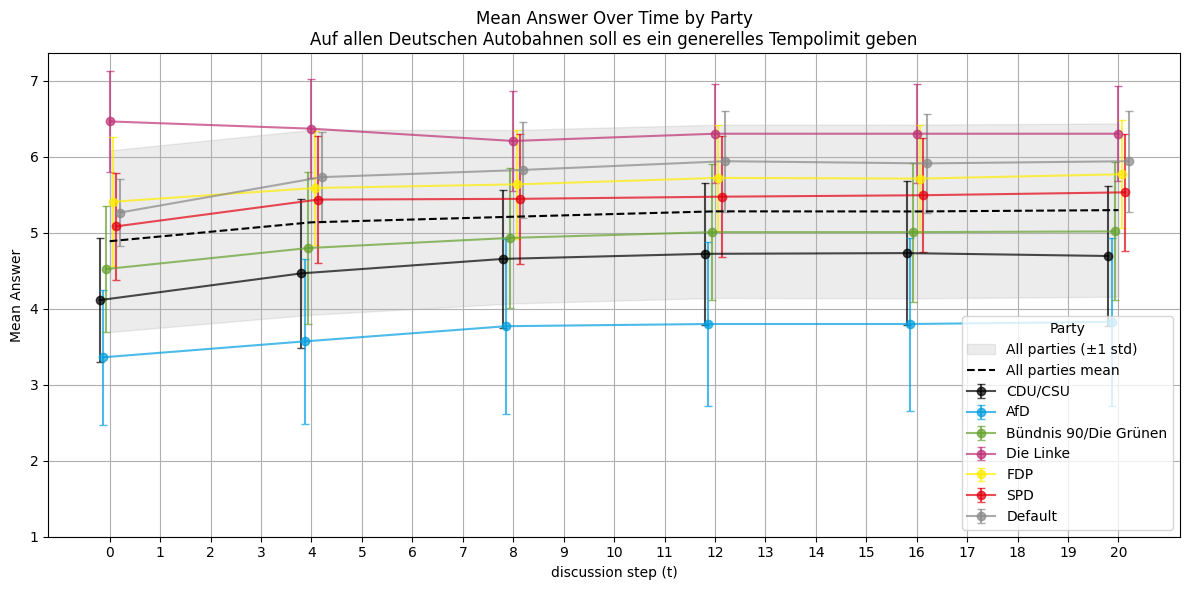

Plotting question index 1


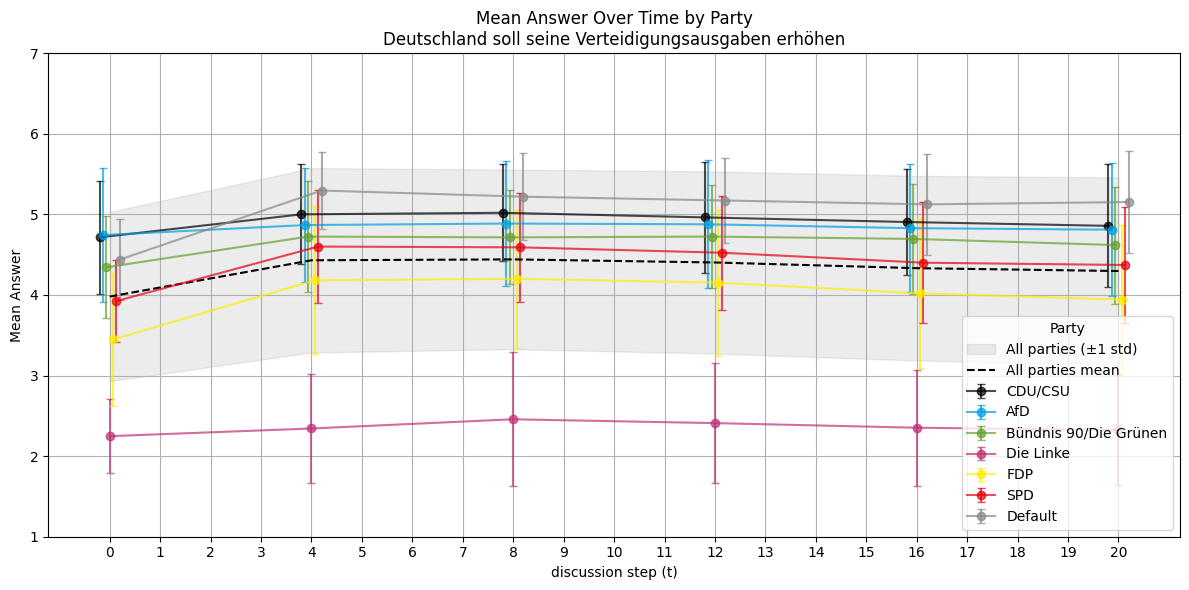

Plotting question index 2


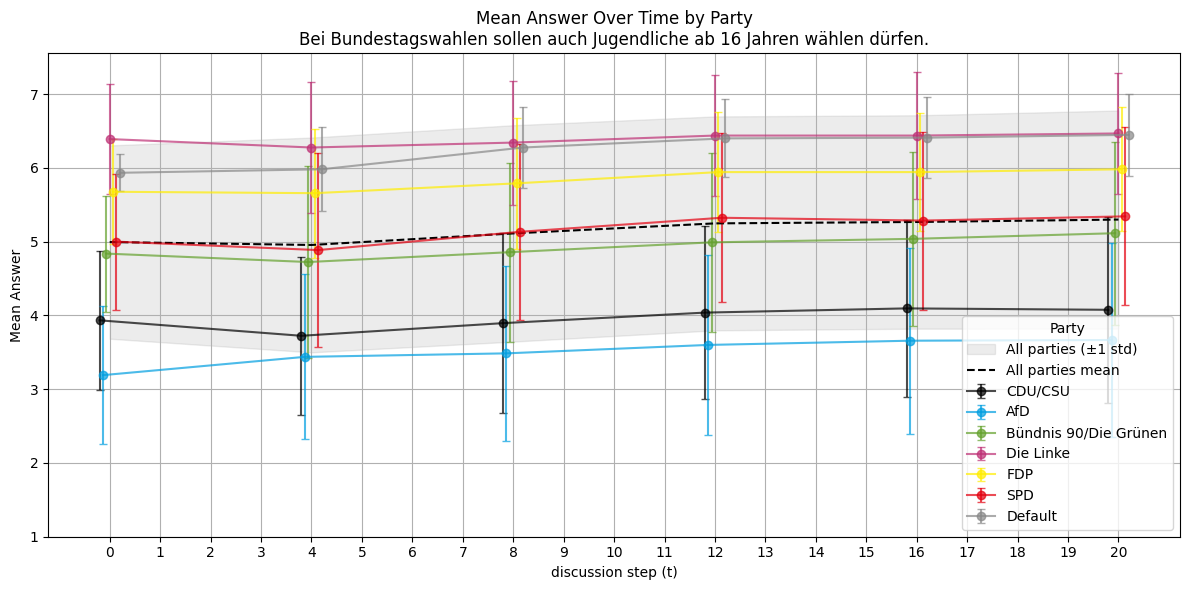

Plotting question index 3


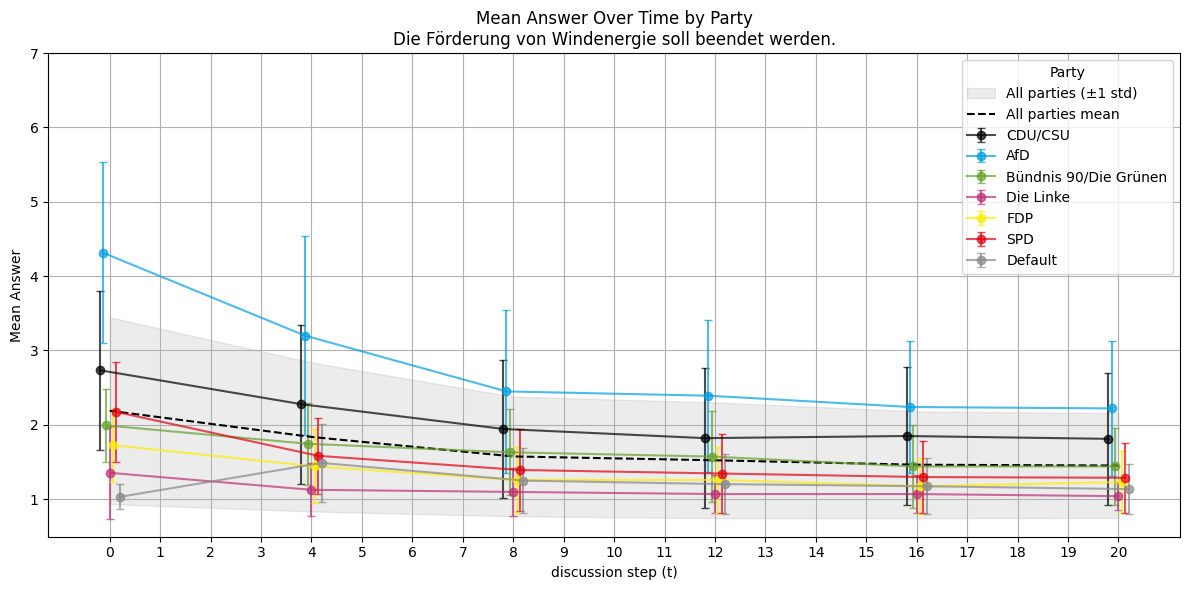

Plotting question index 4


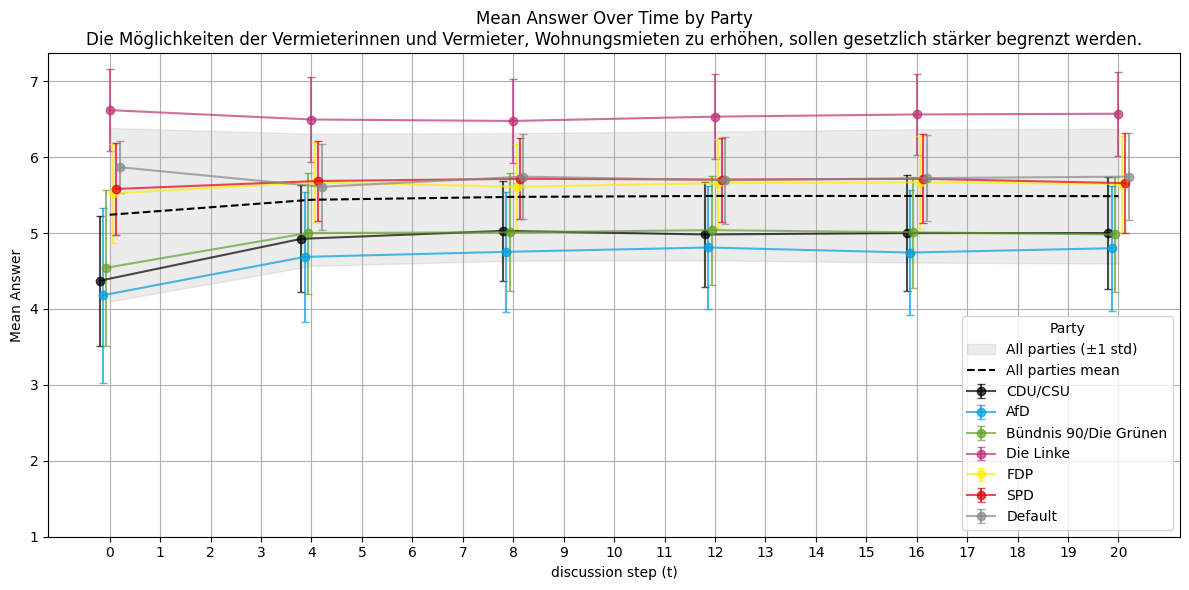

In [ ]:
plot_df = party_df_non_abs.copy()



color_map = {
    "CDU/CSU": "#000000",  # Black
    "SPD": "#E3000F",      # Red
    "Bündnis 90/Die Grünen": "#64A12D",  # Green
    "FDP": "#FFED00",      # Yellow
    "Die Linke": "#BE3075", # Dark Pink
    "AfD": "#009EE0",      # Blue
    "Default": "#888888", # Gray
}
    

plot_df["time"] = plot_df["time"].str.replace("T", "").astype(int)
plot_df["question_index"] = plot_df["question_index"].astype(int)
plot_df["repetition"] = plot_df["repetition"].astype(int)
plot_df = plot_df[(plot_df["answer"] <= 7) & (plot_df["answer"] >= 1)]
plot_df["answer"] = pd.to_numeric(plot_df["answer"], errors="coerce")

parties = list(plot_df["party"].unique())
offsets = np.linspace(-0.2, 0.2, len(parties))  # For party errorbars

print(f"QUESION_INDICES: {plot_df["question_index"].unique()}   ")

for question in plot_df["question_index"].unique():
    print(f"Plotting question index {question}")
    plt.figure(figsize=(12, 6))
    # Plot per-party errorbars, slightly offset
    for i, prompts in enumerate(parties):
        prompt_data = plot_df[
            (plot_df["party"] == prompts) & (plot_df["question_index"] == question)
        ]
        means = prompt_data.groupby("time")["answer"].mean()
        stds = prompt_data.groupby("time")["answer"].std()
        x = means.index + offsets[i]
        plt.errorbar(
            x,
            means.values,
            yerr=stds.values,
            marker="o",
            label=f"{prompts}",
            capsize=3,
            alpha=0.7,
            color=color_map.get(prompts, None),
        )
    # Plot overall mean and std as a field (no offset)
    all_data = plot_df[plot_df["question_index"] == question]
    all_means = all_data.groupby("time")["answer"].mean()
    all_stds = all_data.groupby("time")["answer"].std()
    plt.fill_between(
        all_means.index,
        all_means - all_stds,
        all_means + all_stds,
        color="gray",
        alpha=0.15,
        label="All parties (±1 std)",
    )
    plt.plot(
        all_means.index,
        all_means.values,
        color="black",
        linestyle="--",
        label="All parties mean",
    )
    plt.title(f"Mean Answer Over Time by Party\n{QUESTIONS[question]}")
    plt.xticks(range(0, 21))
    plt.yticks(range(1, 8))
    plt.xlabel("discussion step (t)")
    plt.ylabel("Mean Answer")
    plt.legend(title="Party")
    plt.grid()
    plt.tight_layout()

    if question == 3:
        plt.savefig("figures/normalised_answer_distributions_wind_energy.pdf")

    plt.show()

[np.float64(0.0), np.float64(1.0), np.float64(2.0)]
QUESION_INDICES: [0 1 2 3 4]   
Plotting question index 0


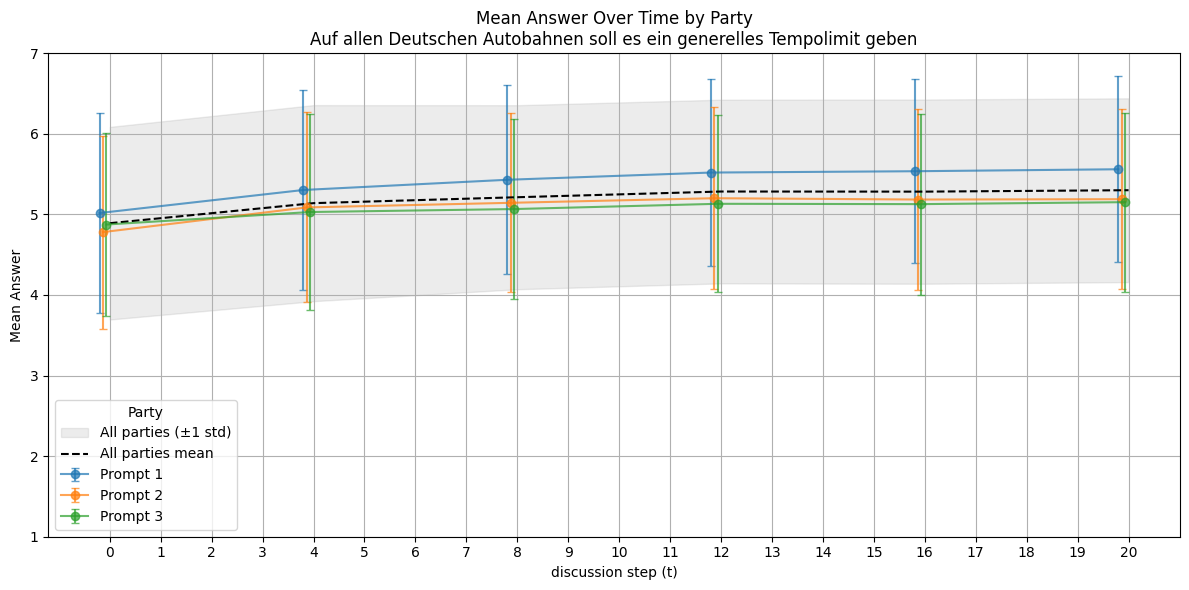

Plotting question index 1


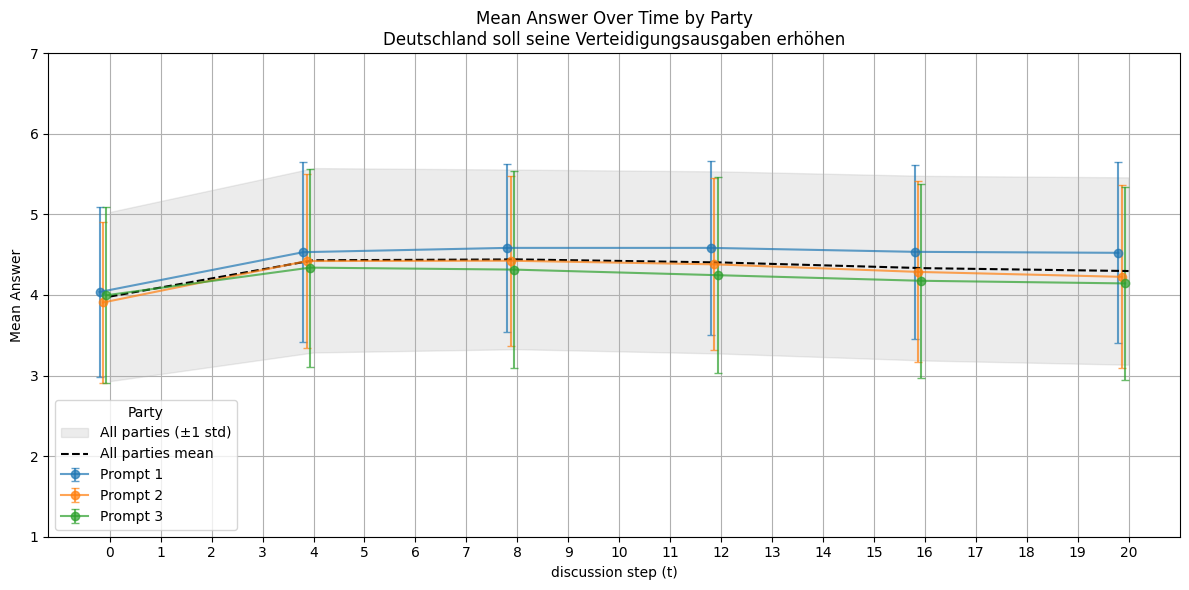

Plotting question index 2


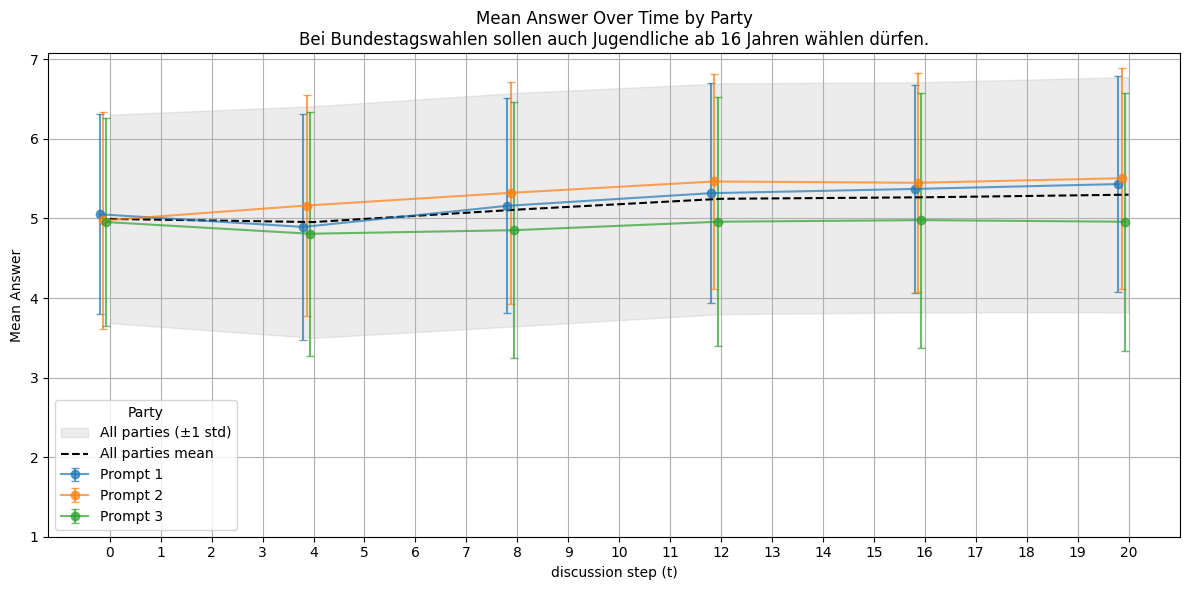

Plotting question index 3


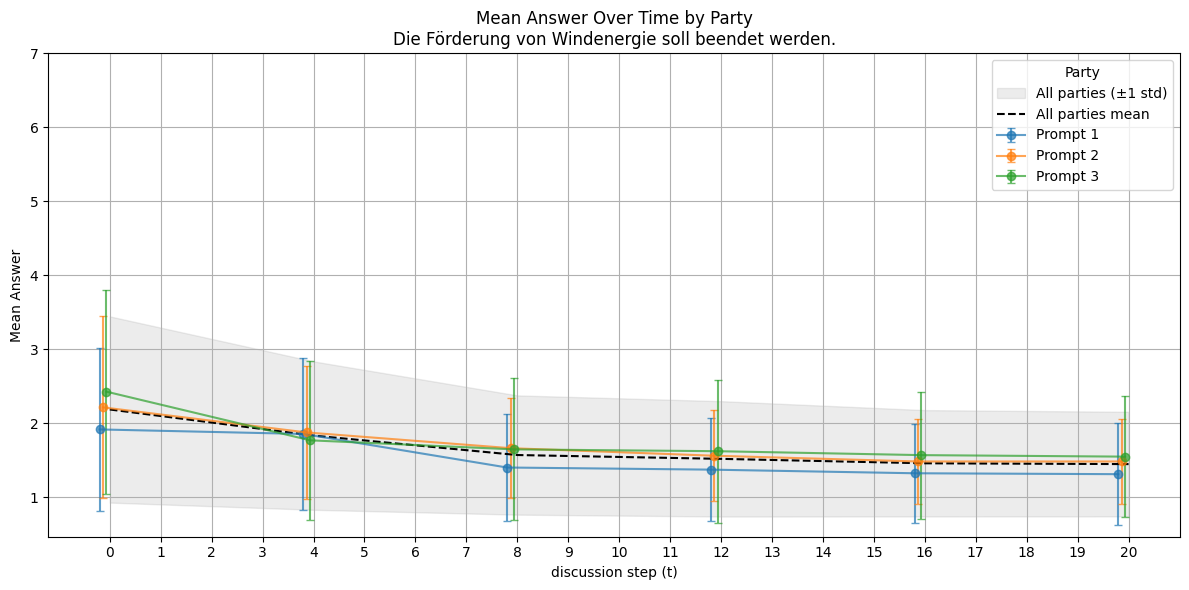

Plotting question index 4


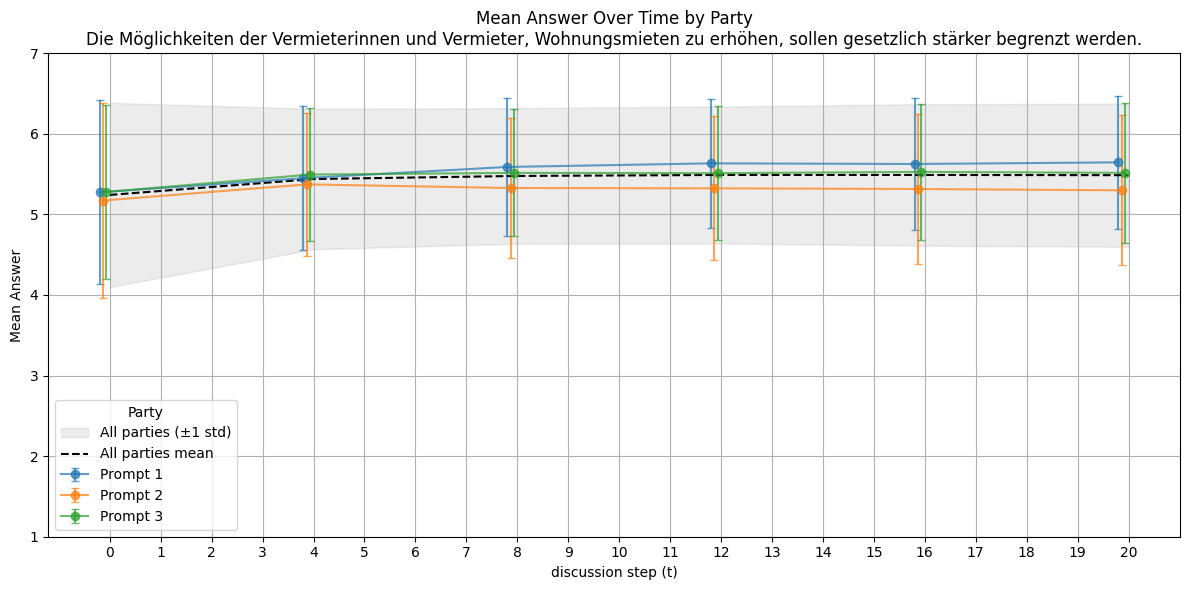

In [66]:
plot_df = party_df_non_abs.copy()

prompt_labels = {
    0: "Prompt 1",
    1: "Prompt 2",
    2: "Prompt 3"
}


    

plot_df["time"] = plot_df["time"].str.replace("T", "").astype(int)
plot_df["question_index"] = plot_df["question_index"].astype(int)
plot_df["repetition"] = plot_df["repetition"].astype(int)
plot_df = plot_df[(plot_df["answer"] <= 7) & (plot_df["answer"] >= 1)]
plot_df["answer"] = pd.to_numeric(plot_df["answer"], errors="coerce")

parties = list(plot_df["party"].unique())
prompts = list(plot_df["version"].unique())
print(prompts)
offsets = np.linspace(-0.2, 0.2, len(parties))  # For party errorbars

print(f"QUESION_INDICES: {plot_df["question_index"].unique()}   ")

for question in plot_df["question_index"].unique():
    print(f"Plotting question index {question}")
    plt.figure(figsize=(12, 6))
    # Plot per-party errorbars, slightly offset
    for i, prompt in enumerate(prompts):
        prompt_data = plot_df[
            (plot_df["version"] == prompt) & (plot_df["question_index"] == question)
        ]
        means = prompt_data.groupby("time")["answer"].mean()
        stds = prompt_data.groupby("time")["answer"].std()
        x = means.index + offsets[i]
        plt.errorbar(
            x,
            means.values,
            yerr=stds.values,
            marker="o",
            label=f"{prompt_labels.get(prompt, prompt)}",
            capsize=3,
            alpha=0.7,
        )
    # Plot overall mean and std as a field (no offset)
    all_data = plot_df[plot_df["question_index"] == question]
    all_means = all_data.groupby("time")["answer"].mean()
    all_stds = all_data.groupby("time")["answer"].std()
    plt.fill_between(
        all_means.index,
        all_means - all_stds,
        all_means + all_stds,
        color="gray",
        alpha=0.15,
        label="All parties (±1 std)",
    )
    plt.plot(
        all_means.index,
        all_means.values,
        color="black",
        linestyle="--",
        label="All parties mean",
    )
    plt.title(f"Mean Answer Over Time by Party\n{QUESTIONS[question]}")
    plt.xticks(range(0, 21))
    plt.yticks(range(1, 8))
    plt.xlabel("discussion step (t)")
    plt.ylabel("Mean Answer")
    plt.legend(title="Party")
    plt.grid()
    plt.tight_layout()

    if question == 3:
        plt.savefig("figures/normalised_answer_distributions_wind_energy.pdf")

    plt.show()

Plotting for question 0: Auf allen Deutschen Autobahnen soll es ein generelles Tempolimit geben


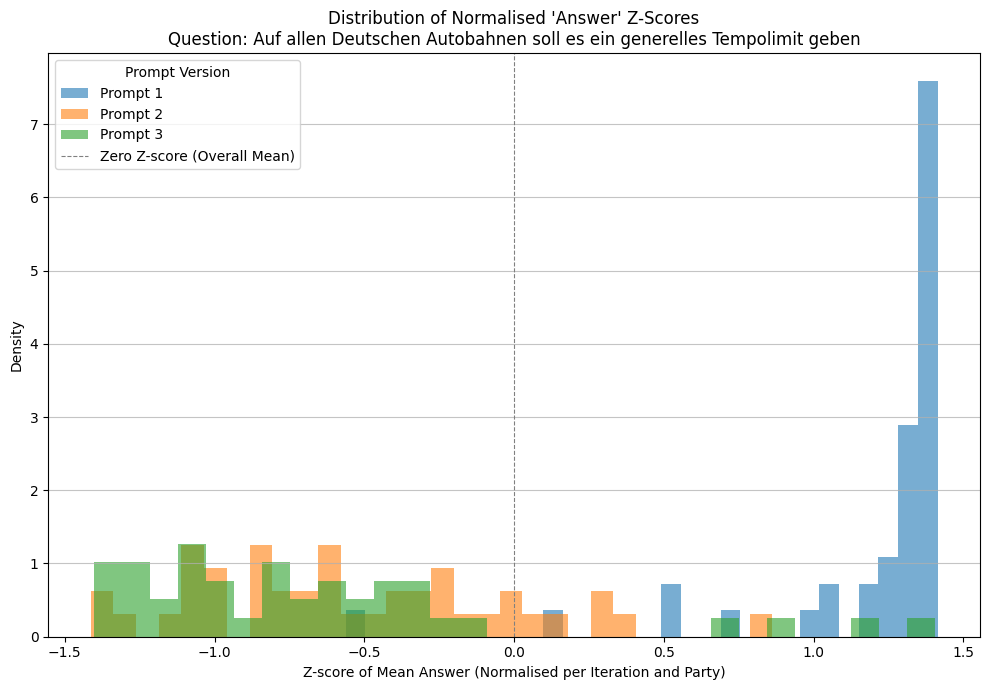

Plotting for question 1: Deutschland soll seine Verteidigungsausgaben erhöhen


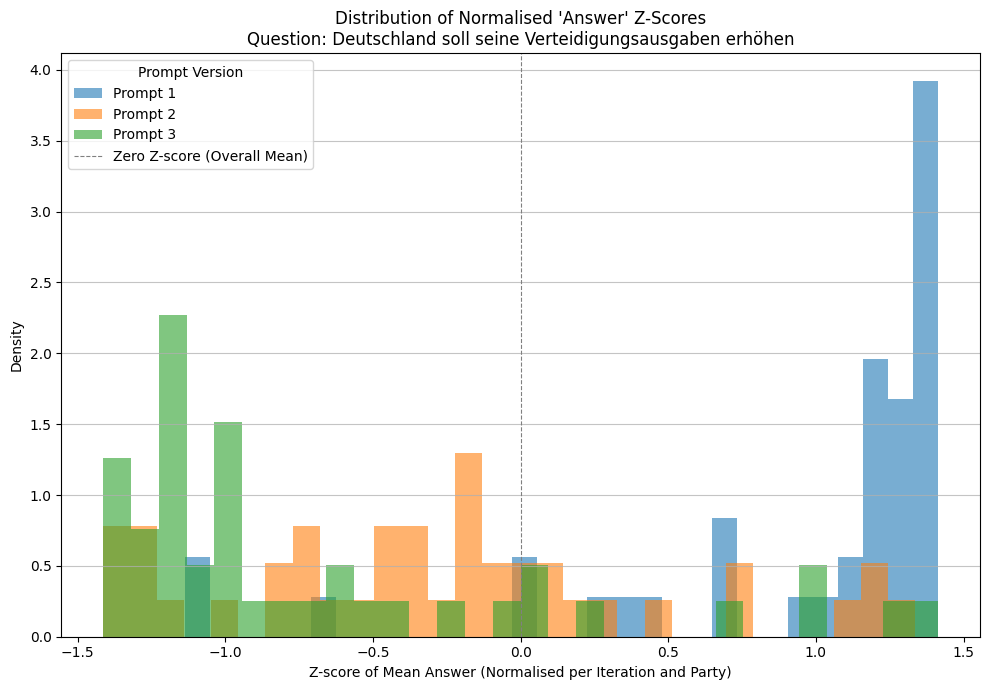

Plotting for question 2: Bei Bundestagswahlen sollen auch Jugendliche ab 16 Jahren wählen dürfen.


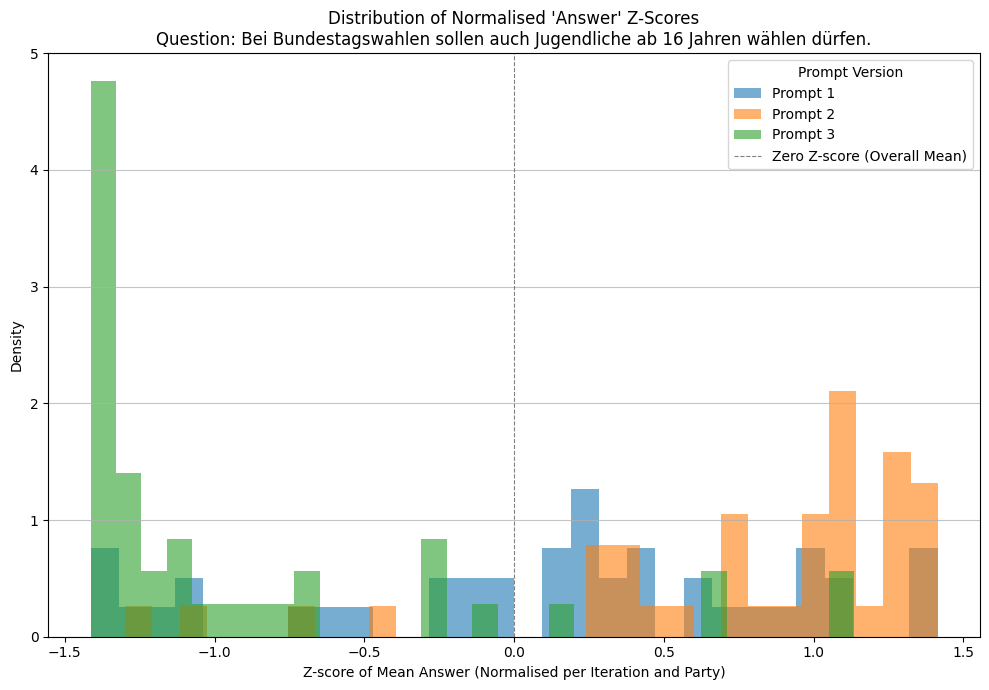

Plotting for question 3: Die Förderung von Windenergie soll beendet werden.


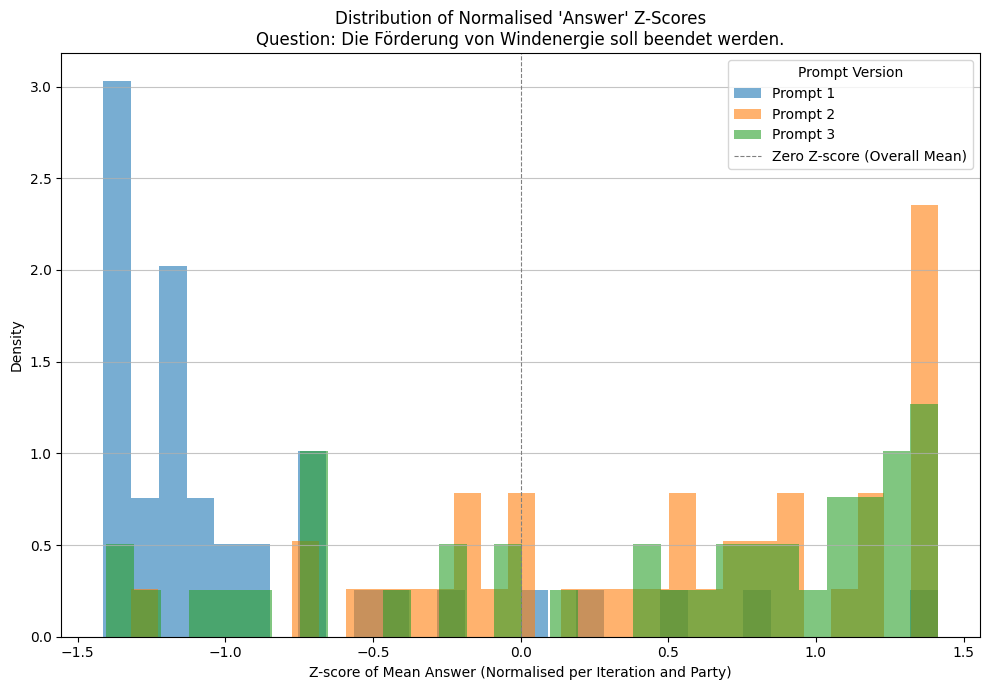

Plotting for question 4: Die Möglichkeiten der Vermieterinnen und Vermieter, Wohnungsmieten zu erhöhen, sollen gesetzlich stärker begrenzt werden.


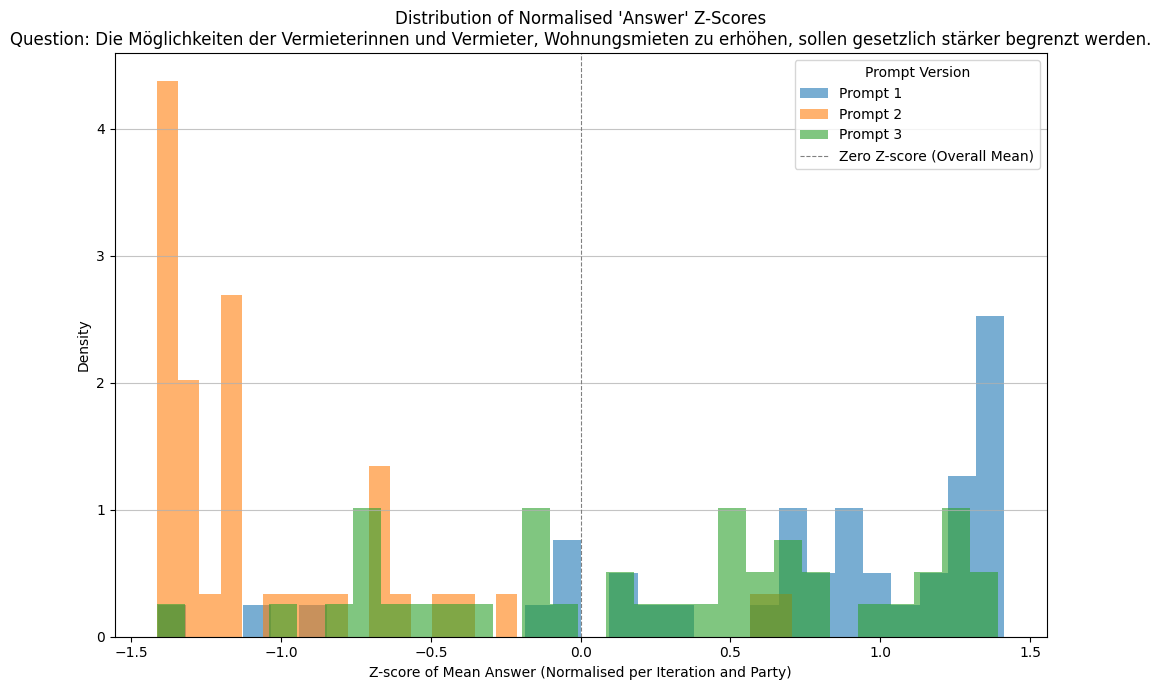

In [ ]:
prompt_labels = {
    0: "Prompt 1",
    1: "Prompt 2",
    2: "Prompt 3"
}

for question in plot_df["question_index"].unique():
    print(f"Plotting for question {question}: {QUESTIONS[int(question)]}")

    # Aggregate means per repetition, party, version for this question
    question_data = plot_df[plot_df["question_index"] == question].groupby(
        ["time", "party", "version"]
    )["answer"].mean().reset_index()
    question_data.rename(columns={"answer": "mean_answer"}, inplace=True)

    # Normalise per time and party
    normalised_df = pd.DataFrame()
    for time in question_data["time"].unique():
        for prompts in question_data["party"].unique():
            iteration_data = question_data[
                (question_data["time"] == time)
                & (question_data["party"] == prompts)
            ].copy()
            scaler = StandardScaler()
            iteration_data["z_score"] = scaler.fit_transform(iteration_data[["mean_answer"]])
            normalised_df = pd.concat([normalised_df, iteration_data])

    plt.figure(figsize=(10, 7))
    versions_sorted = sorted(normalised_df["version"].unique())
    for version_str in versions_sorted:
        prompt_v = int(version_str)
        version_data = normalised_df[normalised_df["version"] == version_str]
        plt.hist(
            version_data["z_score"],
            bins=30,
            alpha=0.6,
            label=prompt_labels[prompt_v],
            density=True,
            histtype='stepfilled'
        )
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.8, label='Zero Z-score (Overall Mean)')
    plt.title(f"Distribution of Normalised 'Answer' Z-Scores\nQuestion: {QUESTIONS[int(question)]}")
    plt.xlabel("Z-score of Mean Answer (Normalised per Iteration and Party)")
    plt.ylabel("Density")
    plt.legend(title="Prompt Version")
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()


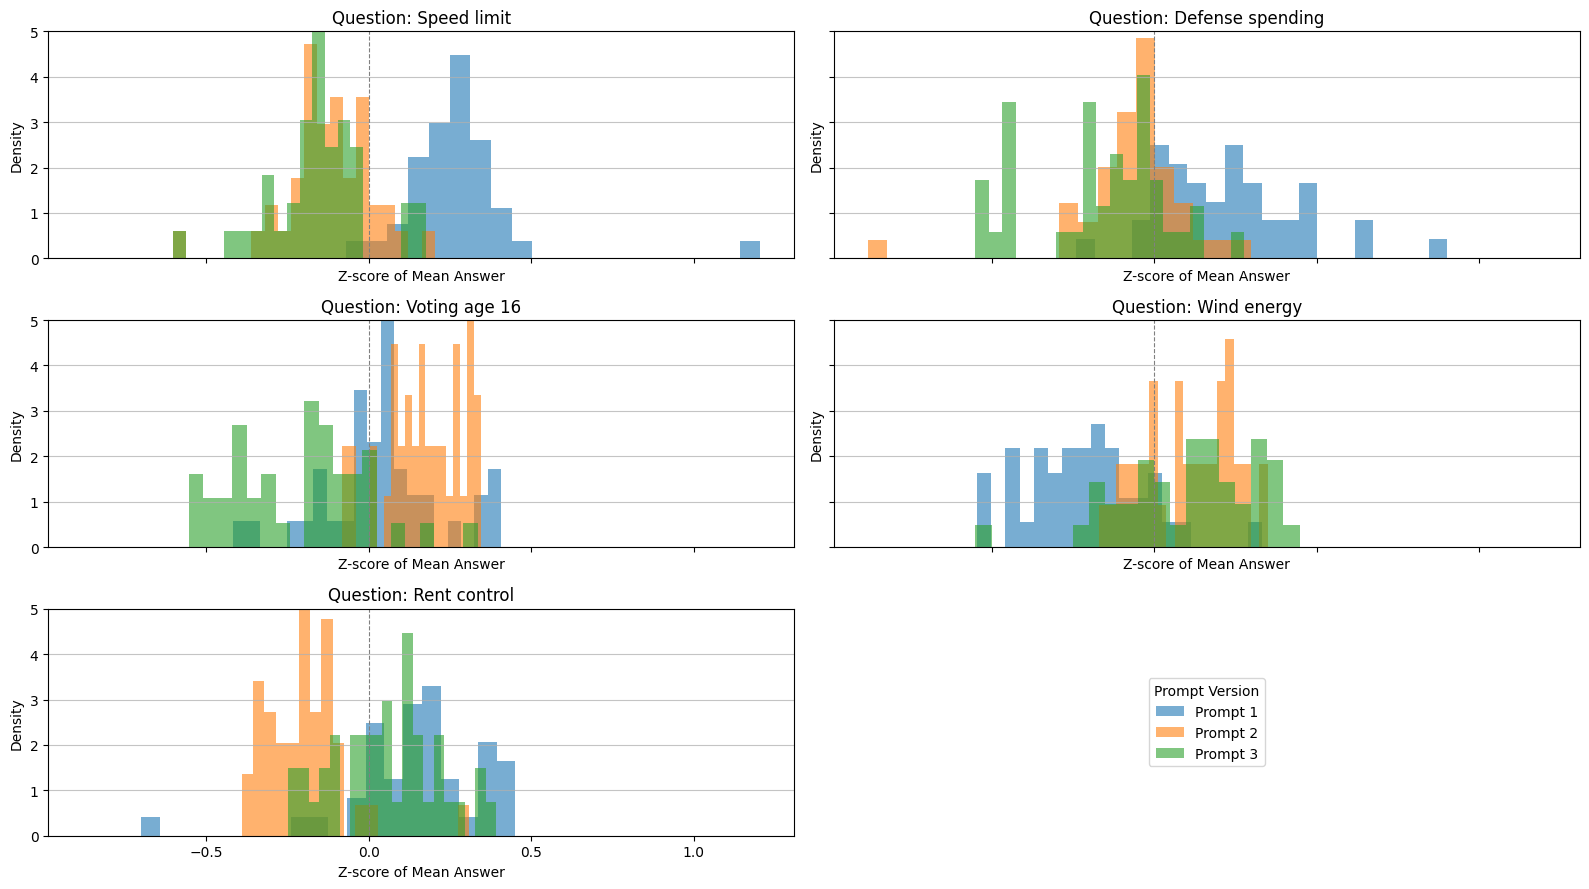

In [71]:
prompt_labels = {
    0: "Prompt 1",
    1: "Prompt 2",
    2: "Prompt 3"
}

fig, axes = plt.subplots(3, 2, figsize=(16, 9), sharex=True, sharey=True)
axes = axes.flatten()

n_questions = len(plot_df["question_index"].unique())

for ax, question in zip(axes, plot_df["question_index"].unique()):
    normalised_df = {0: [], 1: [], 2: []}
    question_data = plot_df[plot_df["question_index"] == question].copy()

    for time in question_data["time"].unique():
        for prompts in question_data["party"].unique():
            iteration_data = question_data[
                 (question_data["time"] == time)
                & (question_data["party"] == prompts)
            ].copy()

            
            scaler = StandardScaler()
            scaler.fit(iteration_data[["answer"]].values.reshape(-1, 1))
            for prompt_v in range(3):
                mean = np.mean(
                    iteration_data[iteration_data["version"] == prompt_v]["answer"]
                )
                z_score = scaler.transform(np.array([[mean]]))[0][0]
                normalised_df[prompt_v].append(z_score)
            





    versions_sorted = sorted(normalised_df.keys())
    for version_str in versions_sorted:
        prompt_v = version_str
        version_data = normalised_df[prompt_v]
        ax.hist(
            version_data,
            bins=20,
            alpha=0.6,
            label=prompt_labels[prompt_v],
            density=True,
            histtype="stepfilled",
        )

    ax.axvline(0, color='grey', linestyle='--', linewidth=0.8)
    ax.set_title(f"Question: {QUESTIONS_SHORT_EN[int(question)]}")
    ax.set_xlabel("Z-score of Mean Answer")
    ax.set_ylabel("Density")
    ax.set_ylim(0, 5)
    ax.grid(axis='y', alpha=0.75)

if n_questions < len(axes):
    legend_ax = axes[n_questions]
    legend_ax.axis("off")  # hide axis
    handles, labels = axes[0].get_legend_handles_labels()
    legend_ax.legend(handles, labels, title="Prompt Version", loc="center")

# Hide any additional unused axes (in case of fewer than 5)
for ax in axes[n_questions+1:]:
    ax.set_visible(False)

plt.tight_layout()
# plt.savefig("figures/normalised_answer_distributions.pdf")
plt.show()


Plotting for question 0: Speed limit
Plotting for question 1: Defense spending
Plotting for question 2: Voting age 16
Plotting for question 3: Wind energy
Plotting for question 4: Rent control


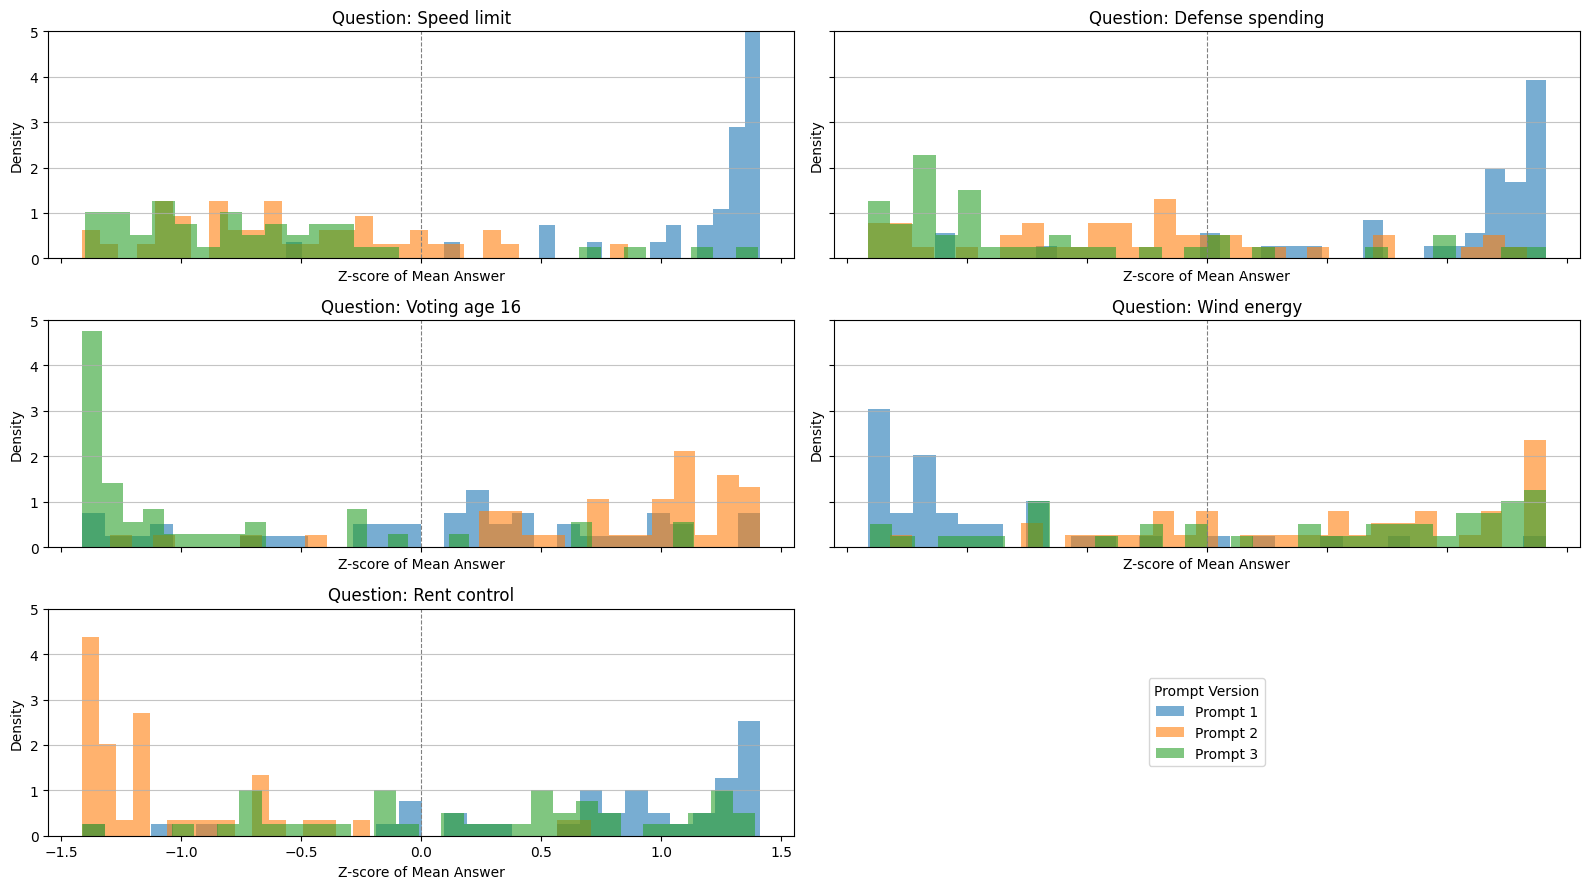

In [ ]:
prompt_labels = {
    0: "Prompt 1",
    1: "Prompt 2",
    2: "Prompt 3"
}

questions = plot_df["question_index"].unique()
n_questions = len(questions)

# Fixed 3x2 grid
fig, axes = plt.subplots(3, 2, figsize=(16, 9), sharex=True, sharey=True)
axes = axes.flatten()

for ax, question in zip(axes, questions):
    print(f"Plotting for question {question}: {QUESTIONS_SHORT_EN[int(question)]}")

    # Aggregate means per repetition, party, version
    question_data = plot_df[plot_df["question_index"] == question].groupby(
        ["time", "party", "version"]
    )["answer"].mean().reset_index()
    question_data.rename(columns={"answer": "mean_answer"}, inplace=True)

    # Normalise per time and party
    normalised_df = pd.DataFrame()
    for time in question_data["time"].unique():
        for prompts in question_data["party"].unique():
            iteration_data = question_data[
                (question_data["time"] == time)
                & (question_data["party"] == prompts)
            ].copy()
            scaler = StandardScaler()
            iteration_data["z_score"] = scaler.fit_transform(iteration_data[["mean_answer"]])
            normalised_df = pd.concat([normalised_df, iteration_data])

    # Plot distributions
    versions_sorted = sorted(normalised_df["version"].unique())
    for version_str in versions_sorted:
        prompt_v = int(version_str)
        version_data = normalised_df[normalised_df["version"] == version_str]
        ax.hist(
            version_data["z_score"],
            bins=30,
            alpha=0.6,
            label=prompt_labels[prompt_v],
            density=True,
            histtype='stepfilled'
        )

    ax.axvline(0, color='grey', linestyle='--', linewidth=0.8)
    ax.set_title(f"Question: {QUESTIONS_SHORT_EN[int(question)]}")
    ax.set_xlabel("Z-score of Mean Answer")
    ax.set_ylabel("Density")
    ax.set_ylim(0, 5)
    ax.grid(axis='y', alpha=0.75)

# Last axis used for legend
if n_questions < len(axes):
    legend_ax = axes[n_questions]
    legend_ax.axis("off")  # hide axis
    handles, labels = axes[0].get_legend_handles_labels()
    legend_ax.legend(handles, labels, title="Prompt Version", loc="center")

# Hide any additional unused axes (in case of fewer than 5)
for ax in axes[n_questions+1:]:
    ax.set_visible(False)

plt.tight_layout()
plt.savefig("figures/normalised_answer_distributions.pdf")
plt.show()

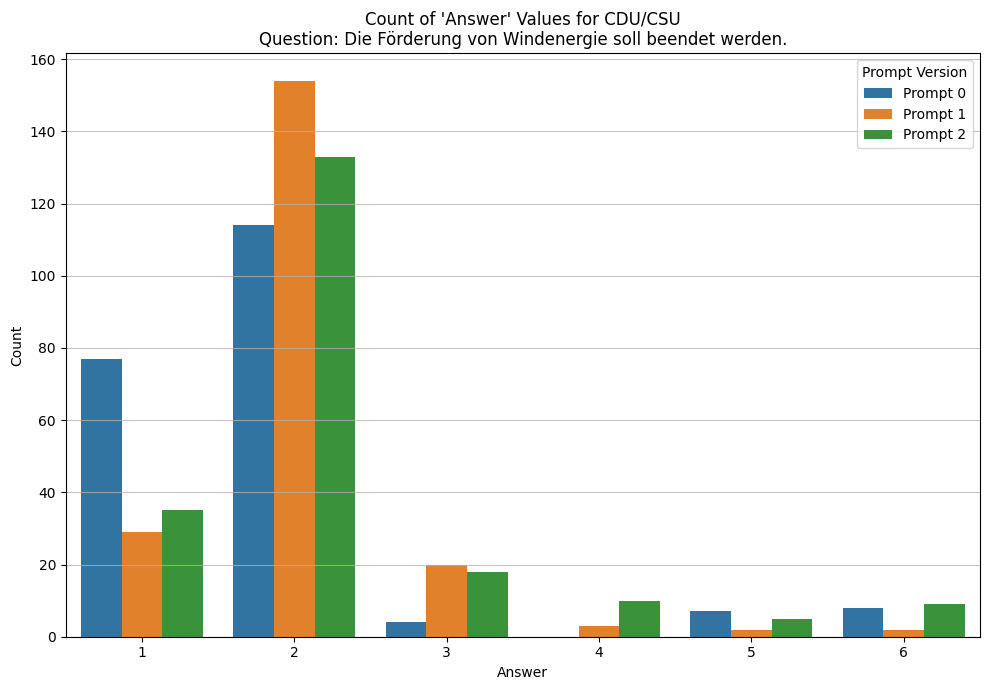

In [12]:
import seaborn as sns

# Only plot bar counts for q3 for party CDU/CSU, split by prompt version
pp = "CDU/CSU"
q3_cdu_df = plot_df[
    (plot_df["question_index"] == 3) & (plot_df["party"] == pp)
].copy()

q3_cdu_df['answer'] = q3_cdu_df['answer'].astype(int)
q3_cdu_df['prompt'] = q3_cdu_df['version'].astype(int)
q3_cdu_df['prompt'] = q3_cdu_df['prompt'].apply(lambda x: f"Prompt {x}")

plt.figure(figsize=(10, 7))
sns.countplot(
    data=q3_cdu_df,
    x="answer",
    hue="prompt",
    palette="tab10",
    dodge=True,
    hue_order=["Prompt 0", "Prompt 1", "Prompt 2"]
)
plt.title(f"Count of 'Answer' Values for {pp}\nQuestion: {QUESTIONS[3]}")
plt.xlabel("Answer")
plt.ylabel("Count")
plt.legend(title="Prompt Version")
plt.grid(axis="y", alpha=0.75)
plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
for question in plot_df["question_index"].unique():
    question_data = plot_df[plot_df["question_index"] == question]
    groups_answers = [group["answer"] for name, group in question_data.groupby("version")]

    stat, p = stats.kruskal(*groups_answers)

    k = len(groups_answers) 
    n_total = sum([len(g) for g in groups_answers]) 
    k = len(groups_answers) 

    epsilon_squared = (stat - k + 1) / (n_total - 1)

    print(f"Epsilon-squared: {epsilon_squared:.3f}")
    print(f"Kruskal-Wallis test for Question {question}: H-statistic = {stat:.3f}, p-value = {p:.3f}")

    
    if p < 0.05: 
        print(f"Significant result for Question {question}. Consider post-hoc tests and pairwise effect sizes.")

        # pairwise comparisons
        posthoc = pairwise_tukeyhsd(endog=question_data["answer"], groups=question_data["version"], alpha=0.05)
        print(posthoc)

        


Epsilon-squared: 0.022
Kruskal-Wallis test for Question 0: H-statistic = 97.197, p-value = 0.000
Significant result for Question 0. Consider post-hoc tests and pairwise effect sizes.
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.2966    0.0 -0.3971 -0.1961   True
   0.0    2.0  -0.3306    0.0 -0.4311 -0.2301   True
   1.0    2.0   -0.034 0.7069 -0.1345  0.0665  False
----------------------------------------------------
Epsilon-squared: 0.010
Kruskal-Wallis test for Question 1: H-statistic = 45.494, p-value = 0.000
Significant result for Question 1. Consider post-hoc tests and pairwise effect sizes.
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.1918    0.0 -0.2896 -0.0941   True
   0.0    2.0  -0.2633    0.0  -0.361 -0.1655   Tru

     party debate_with  version  question_index  repetition  time  answer
0  CDU/CSU         AfD      0.0               0           0     0       3
1      AfD     CDU/CSU      0.0               0           0     0       3
2  CDU/CSU         AfD      0.0               0           1     0       3
3      AfD     CDU/CSU      0.0               0           1     0       4
4  CDU/CSU         AfD      0.0               0           2     0       4
length of version_data for 0: 1470
length of version_data for 1: 1470
length of version_data for 2: 1470
length of version_data for 0: 2940
length of version_data for 1: 2940
length of version_data for 2: 2940
length of version_data for 0: 4410
length of version_data for 1: 4410
length of version_data for 2: 4410
length of version_data for 0: 5880
length of version_data for 1: 5880
length of version_data for 2: 5880
length of version_data for 0: 7350
length of version_data for 1: 7350
length of version_data for 2: 7350


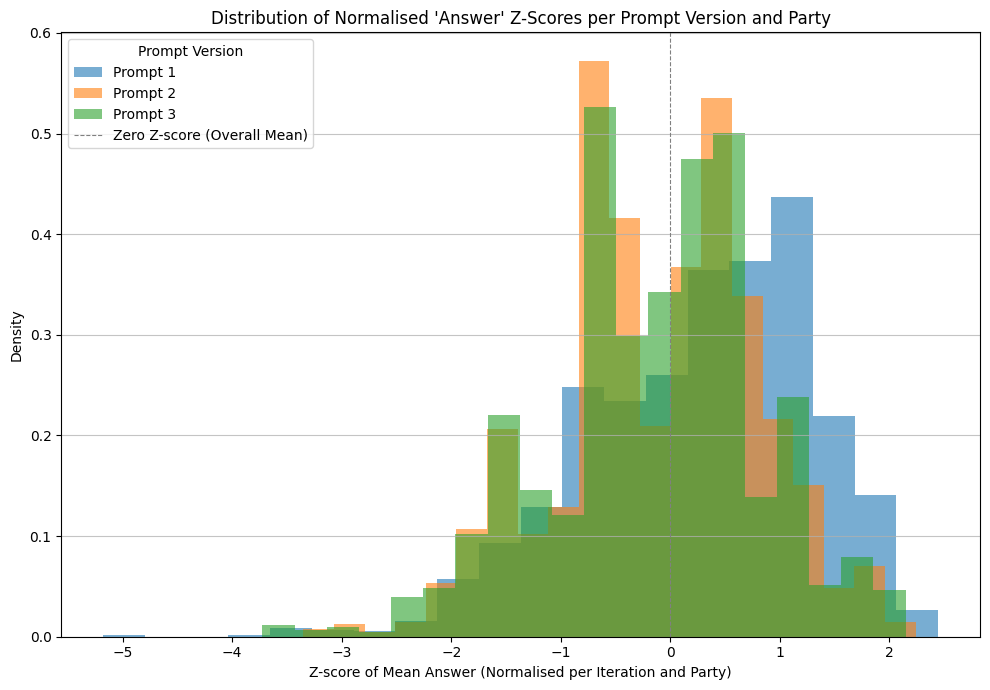

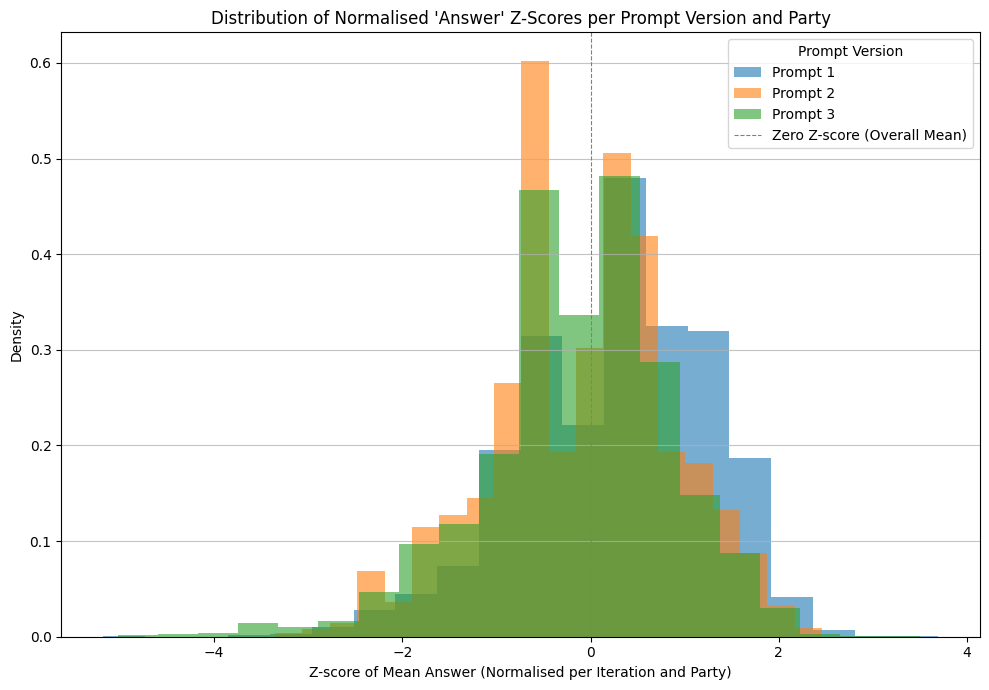

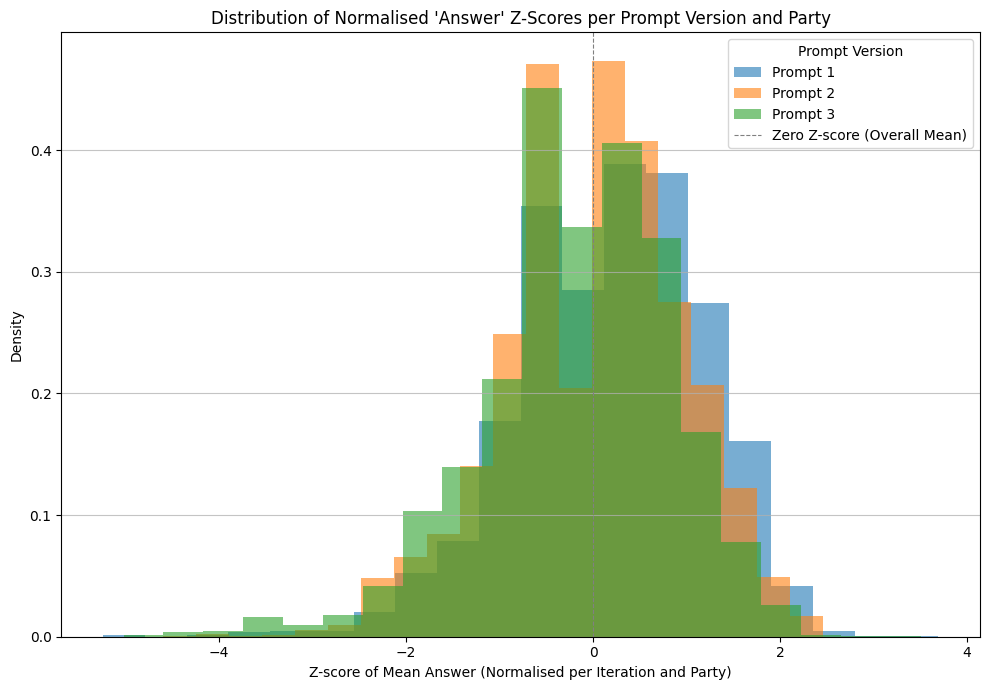

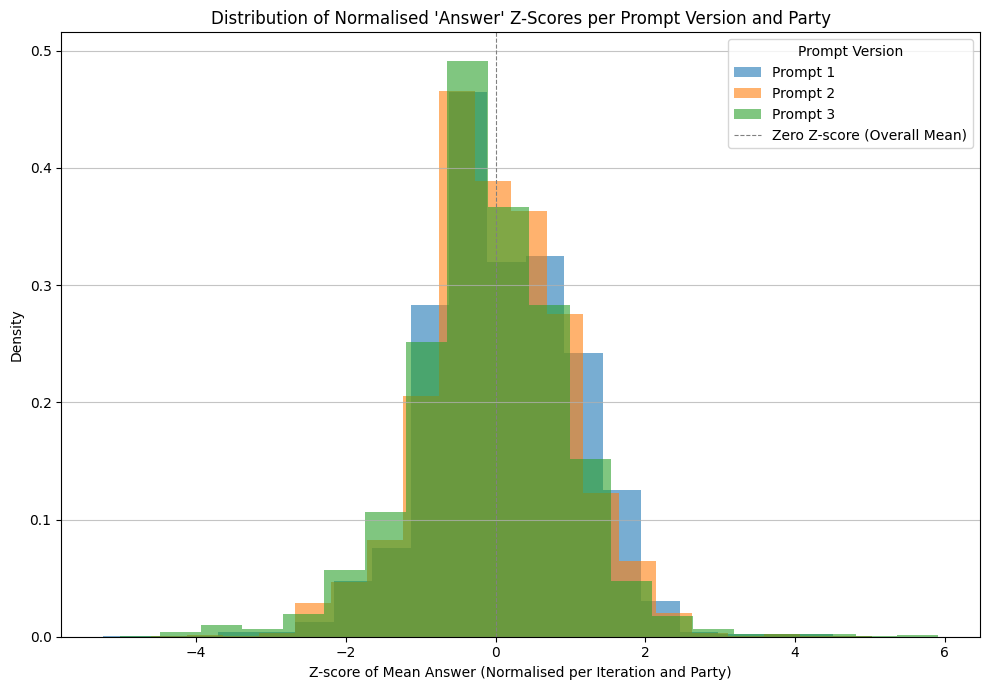

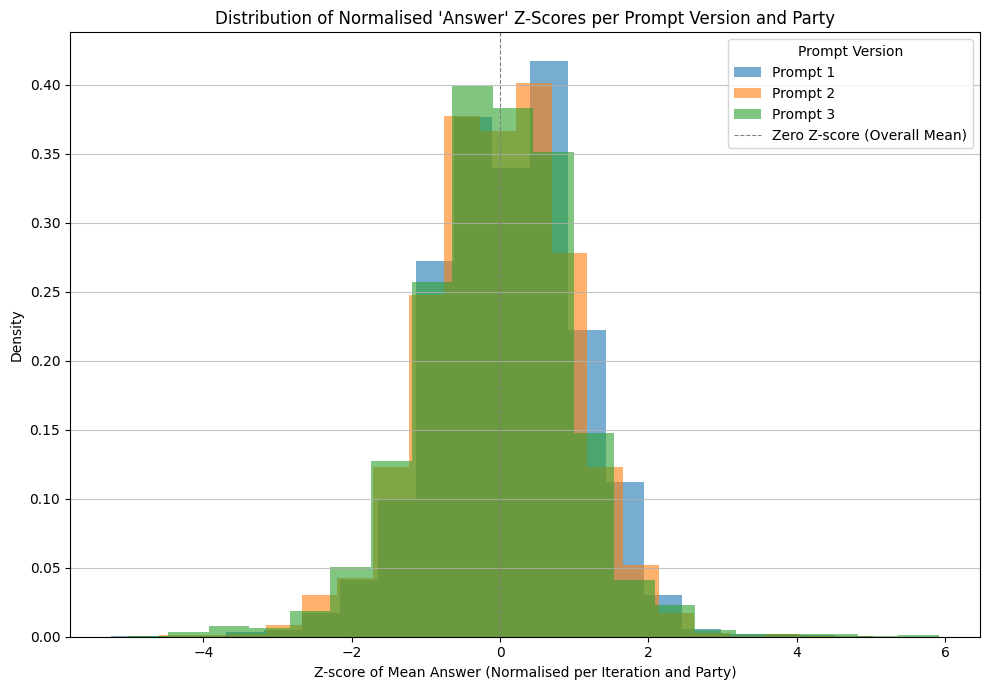

In [ ]:
question_data = plot_df.copy()

# Create an empty dictionary to store normalised data for each version
normalised_df = {0: [], 1: [], 2: []}


print(question_data.head())

for  question in plot_df["question_index"].unique():

    for time in question_data["time"].unique():
        for prompts in question_data["party"].unique():
            # Filter data for the current repetition and party
            iteration_data = question_data[
                (question_data["question_index"] == question)
                & (question_data["time"] == time)
                & (question_data["party"] == prompts)
            ].copy()

            # Fit StandardScaler on the 'mean_answer' for this iteration
            scaler = StandardScaler()
            # Reshape to 2D array as StandardScaler expects this
            scaler.fit(iteration_data[["answer"]].values.reshape(-1, 1))

            for prompt_v in range(3):
                # Filter data for the current version
                data_for_version = iteration_data[
                    iteration_data["version"] == prompt_v
                ]
                

                z_scores: list = scaler.transform(data_for_version["answer"].values.reshape(-1, 1)).flatten().tolist()

                normalised_df[prompt_v].extend(z_scores)



    # plot data
    plt.figure(figsize=(10, 7))
    # Ensure versions are sorted for consistent plotting
    versions_sorted = sorted(normalised_df.keys())
    for version_str in versions_sorted:
        # Extract the numeric part of the version string (e.g., 'out_0' -> 0)
        prompt_v = version_str

        # Filter data for the current version
        version_data = normalised_df[prompt_v]
        print(f"length of version_data for {version_str}: {len(version_data)}")

        plt.hist(
            version_data,
            bins=20,  # You can adjust the number of bins
            alpha=0.6,  # Transparency to see overlaps
            label=prompt_labels[prompt_v],
            density=True,  # Normalise to form a probability density
            histtype="stepfilled",  # A nice style for multiple histograms
        )
    plt.axvline(
        0, color="grey", linestyle="--", linewidth=0.8, label="Zero Z-score (Overall Mean)"
    )  # Add a line at 0 for reference
    plt.title("Distribution of Normalised 'Answer' Z-Scores per Prompt Version and Party")
    plt.xlabel("Z-score of Mean Answer (Normalised per Iteration and Party)")
    plt.ylabel("Density")
    plt.legend(title="Prompt Version")
    plt.grid(axis="y", alpha=0.75)
    plt.tight_layout()

In [15]:
party_df_non_abs

,party,debate_with,version,question_index,repetition,time,answer
0,CDU/CSU,AfD,0.0,0.0,0,T0,3
1,AfD,CDU/CSU,0.0,0.0,0,T0,3
2,CDU/CSU,AfD,0.0,0.0,1,T0,3
3,AfD,CDU/CSU,0.0,0.0,1,T0,4
4,CDU/CSU,AfD,0.0,0.0,2,T0,4
...,...,...,...,...,...,...,...
22045,CDU/CSU,FDP,2.0,4.0,2,T20,5
22046,FDP,CDU/CSU,2.0,4.0,3,T20,5
22047,CDU/CSU,FDP,2.0,4.0,3,T20,5
22048,FDP,CDU/CSU,2.0,4.0,4,T20,5


In [16]:
# LMM - Linearly Mixed Model
# Model: answer ~ iteration + party + version, random intercept for agent_idx within party


# Prepare the main dataframe for LMM once, outside the loop
lmm_data = party_df_non_abs.copy()
lmm_data['version'] = lmm_data['version'].astype('category')
lmm_data = lmm_data.dropna(subset=["answer"]).reset_index(drop=True)
lmm_data["answer"] = pd.to_numeric(lmm_data["answer"], errors="coerce")
# map from 0,4,8,12,16,20 to 0,1,2,3,4,5
lmm_data["time"] = lmm_data["time"].str.replace("T", "").astype(int)
lmm_data["time"] = lmm_data["time"].apply(
    lambda x: x / 4 if pd.notna(x) else np.nan
)
lmm_data["time"] = pd.to_numeric(lmm_data["time"], errors="coerce")
lmm_data["question_index"] = lmm_data["question_index"].astype("category")
lmm_data["party"] = lmm_data["party"].astype("category")
lmm_data["party"] = lmm_data["party"].cat.reorder_categories(
    ["Default", "AfD", "Bündnis 90/Die Grünen", "CDU/CSU", "Die Linke", "FDP", "SPD"],
    ordered=False
)
lmm_data["debate_with"] = lmm_data["debate_with"].astype("category")
lmm_data = lmm_data.reset_index(drop=True)


display(lmm_data)

,party,debate_with,version,question_index,repetition,time,answer
0,CDU/CSU,AfD,0.0,0.0,0,0.0,3
1,AfD,CDU/CSU,0.0,0.0,0,0.0,3
2,CDU/CSU,AfD,0.0,0.0,1,0.0,3
3,AfD,CDU/CSU,0.0,0.0,1,0.0,4
4,CDU/CSU,AfD,0.0,0.0,2,0.0,4
...,...,...,...,...,...,...,...
22045,CDU/CSU,FDP,2.0,4.0,2,5.0,5
22046,FDP,CDU/CSU,2.0,4.0,3,5.0,5
22047,CDU/CSU,FDP,2.0,4.0,3,5.0,5
22048,FDP,CDU/CSU,2.0,4.0,4,5.0,5


# Effect Size via R^2 # Likelyhood test 

In [17]:
# calculate r^2 for the model always missing a fixed effect

full_model = smf.mixedlm(
    "answer ~ time * question_index + party * question_index + version * question_index",
    lmm_data,
    groups=lmm_data["repetition"].astype(str),
    re_formula="~ time" 
).fit(reml=False)  

no_party_model = smf.mixedlm(
    "answer ~ time * question_index + version * question_index",
    lmm_data,
    groups=lmm_data["repetition"].astype(str),
    re_formula="~ time" 
).fit(reml=False)

no_version_model = smf.mixedlm(
    "answer ~ time * question_index + party * question_index",
    lmm_data,
    groups=lmm_data["repetition"].astype(str),
    re_formula="~ time" 
).fit(reml=False)

no_time_model = smf.mixedlm(
    "answer ~ question_index * party  + question_index * version",
    lmm_data,
    groups=lmm_data["repetition"].astype(str),
    re_formula="~ time"
).fit(reml=False)

no_question_model = smf.mixedlm(
    "answer ~ time + party + version",
    lmm_data,
    groups=lmm_data["repetition"].astype(str),
    re_formula="~ time"
).fit(reml=False)


r2_full = r2_score(full_model.fittedvalues, lmm_data["answer"])

r2_no_party = r2_score(no_party_model.fittedvalues, lmm_data["answer"])

r2_no_version = r2_score(no_version_model.fittedvalues, lmm_data["answer"])

r2_no_time = r2_score(no_time_model.fittedvalues, lmm_data["answer"])

r2_no_question = r2_score(no_question_model.fittedvalues, lmm_data["answer"])

print(f"R^2 for full model: {r2_full:.4f}")
print(f"R^2 loss without party: {r2_full - r2_no_party:.4f}")
print(f"R^2 loss without version: {r2_full - r2_no_version:.4f}")
print(f"R^2 loss without time: {r2_full - r2_no_time:.4f}")
print(f"R^2 loss without question: {r2_full - r2_no_question:.4f}")


############


# LRT statistic
lr_stat = 2 * (full_model.llf - no_version_model.llf)

# Degrees of freedom = difference in number of parameters
df_diff = full_model.df_modelwc - no_version_model.df_modelwc

# p-value
p_value = stats.chi2.sf(lr_stat, df_diff)

print(f"LRT statistic: {lr_stat:.2f}")
print(f"df difference: {df_diff}")
print(f"p-value: {p_value:.4f}")

/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood o

R^2 for full model: 0.7580
R^2 loss without party: 0.3933
R^2 loss without version: 0.0079
R^2 loss without time: 0.0089
R^2 loss without question: 35.8120
LRT statistic: 567.31
df difference: 10
p-value: 0.0000


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


# Do agents with strong party affiliation align with their party’s official stance?

In [18]:
# Do agents with strong party affiliation align with their party’s official stance?

print(parties)
print(questions)
print(QUESTIONS)
# table of parties x questions with party opinions, hardcoded
# since questions are from the Wahl-O-Mat they can have true/false/neutral

party_opinions = {
    "CDU/CSU": [False, True, False, False, None],
    "AfD": [False, True, False, True, False],
    'Bündnis 90/Die Grünen': [True, False, True, False, True],
    "Die Linke": [True, False, True, False, True],
    "FDP": [False, True, True, None, False],
    "SPD": [True, True, True, False, True],
    "keine Partei": [None, None, None, None, None]
}



initial_opinions = lmm_data[lmm_data["time"] == 0][["party", "question_index", "answer"]].copy()

fdp_data = initial_opinions[initial_opinions["party"] == "FDP"]

fdp_means = fdp_data.groupby("question_index")["answer"].mean().reset_index()
print("FDP initial opinions means:")
print(fdp_means)
print("FDP initial opinions counts:")
print(party_opinions["FDP"])

# map answers to True/False/Neutral
# answers 1-3 -> False, 4 -> Neutral, 5-7 -> True
def map_answer_to_opinion(answer):
    if answer <= 3:
        return False
    elif answer == 4:
        return None
    elif answer >= 5:
        return True
    else:
        return None
initial_opinions["mapped_answer"] = initial_opinions["answer"].apply(map_answer_to_opinion) 


# calculate the alignment with party opinion # where d(True, True) = 0 and d(False, False) = 0, d(True, False) = 1, d(True, None) = 0.5
def calculate_distance(row):
    party = row["party"]
    question_index = int(row["question_index"])
    mapped_answer = row["mapped_answer"]
    party_opinion = party_opinions.get(party, [None]*5)[question_index]
    if party_opinion == mapped_answer:
        return 0  # Aligned
    elif party_opinion == True and mapped_answer == False:
        return 1  # Opposed
    elif party_opinion == False and mapped_answer == True:
        return 1  # Opposed
    else:
        return 0.5  # Neutral or no opinion


# calculate the allignment for each party and question
initial_opinions["alignment"] = initial_opinions.apply(calculate_distance, axis=1)


# average alignment per party 
average_distance = initial_opinions.groupby("party")["alignment"].mean().reset_index()
average_distance = average_distance.sort_values(by="alignment")
print(average_distance)

def get_party_opinion(row):
    party = row["party"]
    q_index = int(row["question_index"])
    # Ensure the question index is valid for the party_opinions list
    if party in party_opinions and q_index < len(party_opinions[party]):
        return party_opinions[party][q_index]
    return None

initial_opinions["party_opinion"] = initial_opinions.apply(get_party_opinion, axis=1)


# Step 2: Convert boolean/None opinions to a numerical scale for correlation
def opinion_to_numeric(opinion):
    if opinion is True:
        return 1
    elif opinion is False:
        return -1
    else: # This covers None (Neutral)
        return 0

initial_opinions["user_opinion_numeric"] = initial_opinions["mapped_answer"].apply(opinion_to_numeric)
initial_opinions["party_opinion_numeric"] = initial_opinions["party_opinion"].apply(opinion_to_numeric)


# Step 3: Group by party and calculate Spearman's correlation
# We calculate the correlation between the numeric user opinion and the numeric party opinion.
spearman_corr = initial_opinions.groupby("party")[["user_opinion_numeric", "party_opinion_numeric"]].corr(method="spearman")

# The result is a multi-index DataFrame. We can simplify it for a clearer view.
# We only need the correlation value between the two different columns.
rho_values = spearman_corr.unstack().iloc[:, 1]

# Sort the results to see which party has the highest correlation
rho_values_sorted = rho_values.sort_values(ascending=False).reset_index()
rho_values_sorted.columns = ["party", "spearman_rho"]


print("--- Spearman's Rank Correlation (rho) per Party ---")
print(rho_values_sorted)


final_opinions = lmm_data[lmm_data["time"] == 5][["party", "question_index", "answer"]].copy()
final_opinions["mapped_answer"] = final_opinions["answer"].apply(map_answer_to_opinion)
final_opinions["alignment"] = final_opinions.apply(calculate_distance, axis=1)
final_average_distance = final_opinions.groupby("party")["alignment"].mean().reset_index()
final_average_distance = final_average_distance.sort_values(by="alignment")
print("--- Final Opinions Average Alignment ---")
print(final_average_distance)
final_opinions["party_opinion"] = final_opinions.apply(get_party_opinion, axis=1)
final_opinions["user_opinion_numeric"] = final_opinions["mapped_answer"].apply(opinion_to_numeric)
final_opinions["party_opinion_numeric"] = final_opinions["party_opinion"].apply(opinion_to_numeric)
final_spearman_corr = final_opinions.groupby("party")[["user_opinion_numeric", "party_opinion_numeric"]].corr(method="spearman")
final_rho_values = final_spearman_corr.unstack().iloc[:, 1]
final_rho_values_sorted = final_rho_values.sort_values(ascending=False).reset_index()
final_rho_values_sorted.columns = ["party", "spearman_rho"]
print("--- Final Opinions Spearman's Rank Correlation (rho) per Party ---")
print(final_rho_values_sorted)


['CDU/CSU', 'AfD', 'Bündnis 90/Die Grünen', 'Die Linke', 'FDP', 'SPD', 'Default']
[0 1 2 3 4]
['Auf allen Deutschen Autobahnen soll es ein generelles Tempolimit geben', 'Deutschland soll seine Verteidigungsausgaben erhöhen', 'Bei Bundestagswahlen sollen auch Jugendliche ab 16 Jahren wählen dürfen.', 'Die Förderung von Windenergie soll beendet werden.', 'Die Möglichkeiten der Vermieterinnen und Vermieter, Wohnungsmieten zu erhöhen, sollen gesetzlich stärker begrenzt werden.']
FDP initial opinions means:
  question_index    answer
0            0.0  5.409524
1            1.0  3.447619
2            2.0  5.676190
3            3.0  1.723810
4            4.0  5.523810
FDP initial opinions counts:
[False, True, True, None, False]
                   party  alignment
4              Die Linke   0.006667
6                    SPD   0.174286
2  Bündnis 90/Die Grünen   0.290476
1                    AfD   0.332381
3                CDU/CSU   0.349524
0                Default   0.443810
5               

/var/folders/7m/xjp08lvs2dg885vy_yybj_2r0000gn/T/ipykernel_9981/2721431715.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fdp_means = fdp_data.groupby("question_index")["answer"].mean().reset_index()
/var/folders/7m/xjp08lvs2dg885vy_yybj_2r0000gn/T/ipykernel_9981/2721431715.py:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_distance = initial_opinions.groupby("party")["alignment"].mean().reset_index()
/var/folders/7m/xjp08lvs2dg885vy_yybj_2r0000gn/T/ipykernel_9981/2721431715.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pan

In [ ]:
# same but whith Cohens Kappa

from sklearn.metrics import cohen_kappa_score
# Calculate Cohen's Kappa for each party
initial_opinions["user_opinion_str"] = initial_opinions["mapped_answer"].apply(lambda x: str(x))
initial_opinions["party_opinion_str"] = initial_opinions["party_opinion"].apply(lambda x: str(x))

kappa_values = {}
for prompts, group in initial_opinions.groupby("party"):
    if len(group["user_opinion_str"].unique()) > 1 and len(group["party_opinion_str"].unique()) > 1:
        kappa = cohen_kappa_score(group["user_opinion_str"], group["party_opinion_str"])
        kappa_values[prompts] = kappa
    else:
        kappa_values[prompts] = None  # Not enough variation to compute Kappa
kappa_df = pd.DataFrame(list(kappa_values.items()), columns=["party", "cohen_kappa"])
kappa_df = kappa_df.sort_values(by="cohen_kappa", ascending=False)
print("--- Cohen's Kappa per Party ---")
print(kappa_df)


/var/folders/7m/xjp08lvs2dg885vy_yybj_2r0000gn/T/ipykernel_9981/3740478194.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for party, group in initial_opinions.groupby("party"):


--- Cohen's Kappa per Party ---
                   party  cohen_kappa
4              Die Linke     0.980299
6                    SPD     0.453237
2  Bündnis 90/Die Grünen     0.317897
1                    AfD     0.270897
3                CDU/CSU     0.178853
5                    FDP    -0.265170
0                Default          NaN


# Distance from Initial Opinion 
In the following I'll be answering RQ2: "Does discussion cause agents' opinions to significantly shift from their starting points and converge towards more uniform stances?" by calculting the distance from the original opinion


In [20]:
lmm_data

,party,debate_with,version,question_index,repetition,time,answer
0,CDU/CSU,AfD,0.0,0.0,0,0.0,3
1,AfD,CDU/CSU,0.0,0.0,0,0.0,3
2,CDU/CSU,AfD,0.0,0.0,1,0.0,3
3,AfD,CDU/CSU,0.0,0.0,1,0.0,4
4,CDU/CSU,AfD,0.0,0.0,2,0.0,4
...,...,...,...,...,...,...,...
22045,CDU/CSU,FDP,2.0,4.0,2,5.0,5
22046,FDP,CDU/CSU,2.0,4.0,3,5.0,5
22047,CDU/CSU,FDP,2.0,4.0,3,5.0,5
22048,FDP,CDU/CSU,2.0,4.0,4,5.0,5


In [21]:
display(formatted_df)
bla = formatted_df.copy()

# remove columns with missing values
bla = bla.dropna(axis=1, how="any")

display(bla)

# Calculate distance from initial opinion for each timepoint
for t in ["T0", "T4", "T8", "T12", "T16", "T20"]:
    bla[f"d{t[1:]}"] = abs(bla[t] - bla["T0"])

# Optionally, also include d0 (which is always zero)
#bla["d0"] = 0
display(bla)


,party,debate_with,repetition,question_index,version,T0,T4,T8,T12,T16,T20
0,CDU/CSU,AfD,0,0.0,0.0,3,6,6,6,6,5
1,AfD,CDU/CSU,0,0.0,0.0,3,3,3,3,3,3
2,CDU/CSU,AfD,1,0.0,0.0,3,4,4,4,4,4
3,AfD,CDU/CSU,1,0.0,0.0,4,5,5,5,5,5
4,CDU/CSU,AfD,2,0.0,0.0,4,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...
3670,CDU/CSU,FDP,2,4.0,2.0,4,4,5,5,4,5
3671,FDP,CDU/CSU,3,4.0,2.0,6,6,5,6,6,5
3672,CDU/CSU,FDP,3,4.0,2.0,4,5,5,5,5,5
3673,FDP,CDU/CSU,4,4.0,2.0,5,5,5,5,5,5


,party,debate_with,repetition,question_index,version,T0,T4,T8,T12,T16,T20
0,CDU/CSU,AfD,0,0.0,0.0,3,6,6,6,6,5
1,AfD,CDU/CSU,0,0.0,0.0,3,3,3,3,3,3
2,CDU/CSU,AfD,1,0.0,0.0,3,4,4,4,4,4
3,AfD,CDU/CSU,1,0.0,0.0,4,5,5,5,5,5
4,CDU/CSU,AfD,2,0.0,0.0,4,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...
3670,CDU/CSU,FDP,2,4.0,2.0,4,4,5,5,4,5
3671,FDP,CDU/CSU,3,4.0,2.0,6,6,5,6,6,5
3672,CDU/CSU,FDP,3,4.0,2.0,4,5,5,5,5,5
3673,FDP,CDU/CSU,4,4.0,2.0,5,5,5,5,5,5


,party,debate_with,repetition,question_index,version,T0,T4,T8,T12,T16,T20,d0,d4,d8,d12,d16,d20
0,CDU/CSU,AfD,0,0.0,0.0,3,6,6,6,6,5,0,3,3,3,3,2
1,AfD,CDU/CSU,0,0.0,0.0,3,3,3,3,3,3,0,0,0,0,0,0
2,CDU/CSU,AfD,1,0.0,0.0,3,4,4,4,4,4,0,1,1,1,1,1
3,AfD,CDU/CSU,1,0.0,0.0,4,5,5,5,5,5,0,1,1,1,1,1
4,CDU/CSU,AfD,2,0.0,0.0,4,5,5,5,5,5,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3670,CDU/CSU,FDP,2,4.0,2.0,4,4,5,5,4,5,0,0,1,1,0,1
3671,FDP,CDU/CSU,3,4.0,2.0,6,6,5,6,6,5,0,0,1,0,0,1
3672,CDU/CSU,FDP,3,4.0,2.0,4,5,5,5,5,5,0,1,1,1,1,1
3673,FDP,CDU/CSU,4,4.0,2.0,5,5,5,5,5,5,0,0,0,0,0,0


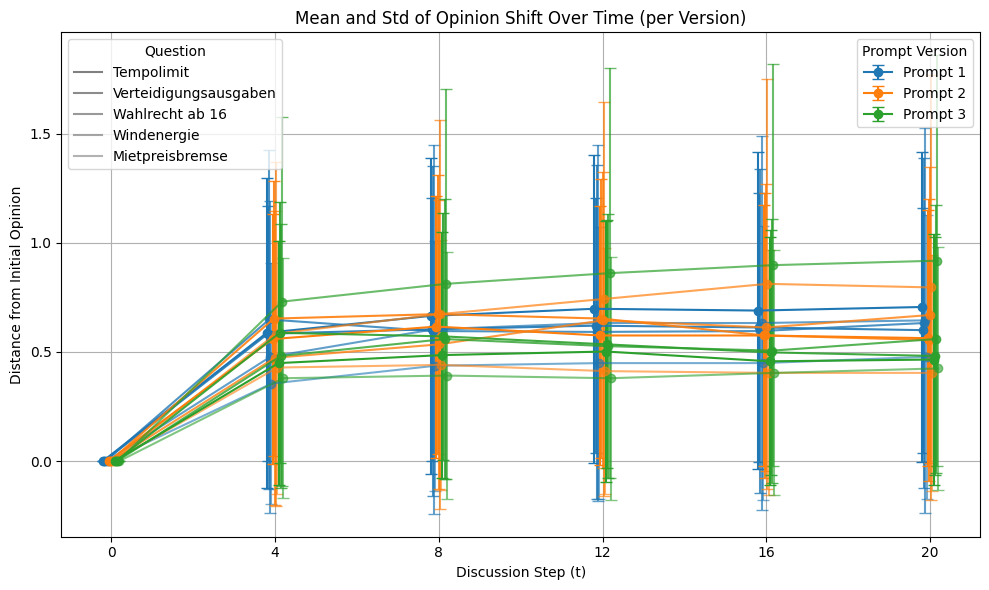

In [22]:
timepoints = ["d0", "d4", "d8", "d12", "d16", "d20"]
prompt_versions = bla["version"].unique()
offsets = np.linspace(
    -0.2, 0.2, len(prompt_versions) * len(QUESTION_INDICES)
)  # Offset for each version and question index

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]
opaqueness = [1, 0.9, 0.8, 0.7, 0.6]  # Opaqueness for each question index


# ...existing code...
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Store handles for legends
prompt_handles = []
question_handles = []

for i, version in enumerate(prompt_versions):
    question_counter = 0
    for question_index in bla["question_index"].unique():
        version_data = bla[
            (bla["version"] == version) & (bla["question_index"] == question_index)
        ]
        means = [version_data[tp].mean() for tp in timepoints]
        stds = [version_data[tp].std() for tp in timepoints]

        offset_i = i * len(QUESTION_INDICES) + question_counter

        x_vals = (
            np.array([int(tp[1:]) if tp != "d0" else 0 for tp in timepoints])
            + offsets[int(offset_i)]
        )
        line = ax.errorbar(
            x_vals,
            means,
            yerr=stds,
            marker="o",
            capsize=4,
            label=f"Prompt {i}",
            color=colors[i],
            alpha=opaqueness[question_counter],
        )
        if question_counter == 0:
            prompt_handles.append(line)
        if i == 0:
            # Dummy lines for question legend
            (dummy,) = ax.plot(
                [],
                [],
                color="gray",
                alpha=opaqueness[question_counter],
                label=f"Question {question_index}",
            )
            question_handles.append(dummy)
        question_counter += 1

plt.xticks([0, 4, 8, 12, 16, 20])
plt.xlabel("Discussion Step (t)")
plt.ylabel("Distance from Initial Opinion")
plt.title("Mean and Std of Opinion Shift Over Time (per Version)")
plt.grid(True)

# First legend: Prompt Version (color)
legend1 = ax.legend(
    prompt_handles,
    [f"Prompt {i + 1}" for i in range(len(prompt_versions))],
    title="Prompt Version",
    loc="upper right",
)
ax.add_artist(legend1)

# Second legend: Question (opaqueness)
legend2 = ax.legend(
    question_handles,
    [QUESTIONS_SHORT[int(q)] for q in bla["question_index"].unique()],
    title="Question",
    loc="upper left",
)

plt.tight_layout()
plt.show()


n_questions < len(axes)


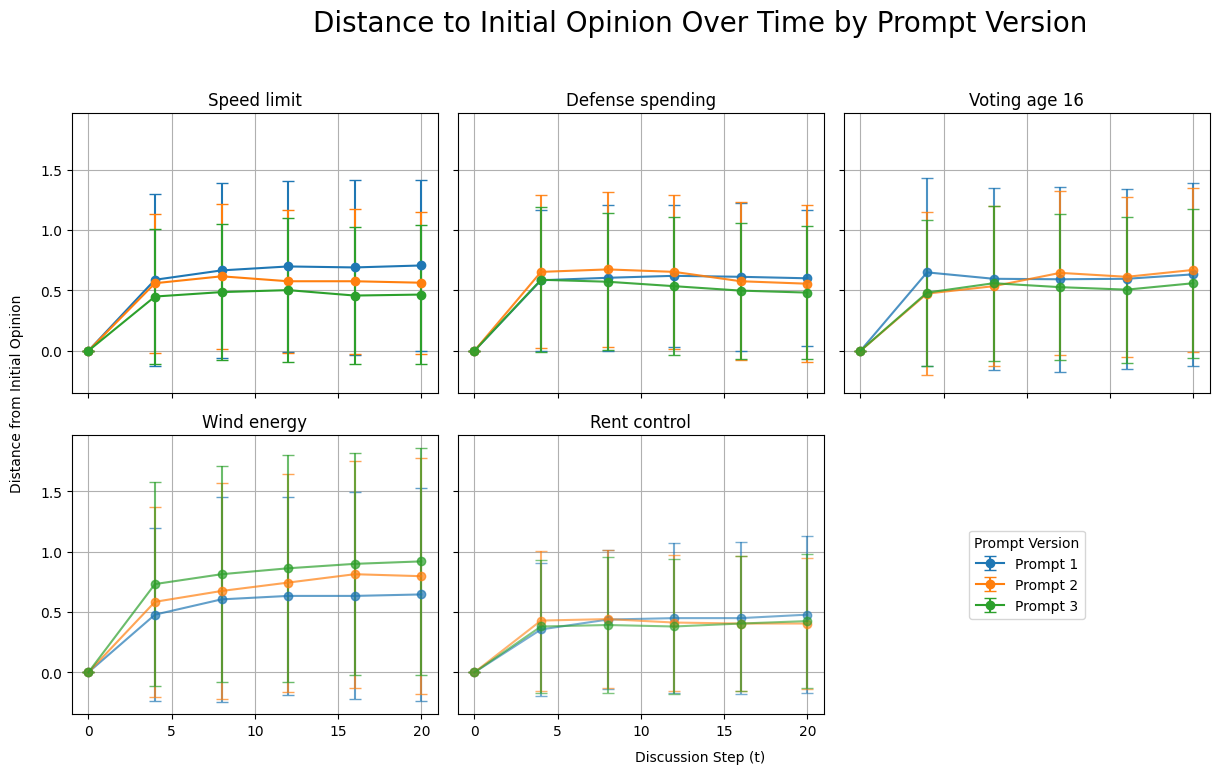

In [23]:
timepoints = ["d0", "d4", "d8", "d12", "d16", "d20"]
prompt_versions = bla["version"].unique()
num_questions = bla["question_index"].nunique()

rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 8), sharex=True, sharey=True)
fig.suptitle("Distance to Initial Opinion Over Time by Prompt Version", fontsize=20)
axes = axes.flatten()

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]
opaqueness = [1, 0.9, 0.8, 0.7, 0.6]  # per question index

prompt_handles = []

for ax, question_index in zip(axes, bla["question_index"].unique()):
    for i, version in enumerate(prompt_versions):
        version_data = bla[
            (bla["version"] == version) & (bla["question_index"] == question_index)
        ]
        means = [version_data[tp].mean() for tp in timepoints]
        stds = [version_data[tp].std() for tp in timepoints]

        x_vals = [int(tp[1:]) if tp != "d0" else 0 for tp in timepoints]

        line = ax.errorbar(
            x_vals,
            means,
            yerr=stds,
            marker="o",
            capsize=4,
            label=f"Prompt {i+1}",
            color=colors[i],
            alpha=opaqueness[int(question_index) % len(opaqueness)],
        )

        if question_index == 0:  # only collect handles once
            prompt_handles.append(line)

    ax.set_title(f"{QUESTIONS_SHORT_EN[int(question_index)]}")
    ax.grid(True)


# Shared labels
fig.text(0.5, 0.04, "Discussion Step (t)", ha="center")
fig.text(0.04, 0.5, "Distance from Initial Opinion", va="center", rotation="vertical")



if n_questions < len(axes):
    print("n_questions < len(axes)")
    legend_ax = axes[n_questions]
    legend_ax.axis("off")  # hide axis
    handles, labels = axes[0].get_legend_handles_labels()
    legend_ax.legend(handles, labels, title="Prompt Version", loc="center")

# Hide unused subplot if fewer than 6
for ax in axes[num_questions+1:]:
    ax.set_visible(False)


# Shared legend: Prompt Versions
# fig.legend(
#     prompt_handles,
#     [f"Prompt {i+1}" for i in range(len(prompt_versions))],
#     title="Prompt Version",
#     loc="upper right"
# )

plt.tight_layout(rect=[0.05, 0.05, 0.85, 0.95])
plt.savefig("figures/opinion_shift_per_version.pdf")
plt.show()


In [24]:
# flatten the data so instead of having d0, d4, d8, d12, d16, d20 as columns, we have a single column for distance and a column for time
xx = []
for version_label, df in enumerate(bla.groupby("version")):
    version_df = df[1]
    version_df = version_df.melt(
        id_vars=["party", "debate_with", "repetition", "version", "question_index"],
        value_vars=[f"d{t[1:]}" for t in timepoints],
        var_name="time",
        value_name="distance"
    )
    version_df["time"] = version_df["time"].str.replace("d", "").astype(int)
    version_df["version"] = version_label
    xx.append(version_df)
# Concatenate all versions into a single DataFrame

formatted_df_distance = pd.concat(xx, ignore_index=True)

formatted_df_distance

,party,debate_with,repetition,version,question_index,time,distance
0,CDU/CSU,AfD,0,0,0.0,0,0
1,AfD,CDU/CSU,0,0,0.0,0,0
2,CDU/CSU,AfD,1,0,0.0,0,0
3,AfD,CDU/CSU,1,0,0.0,0,0
4,CDU/CSU,AfD,2,0,0.0,0,0
...,...,...,...,...,...,...,...
22045,CDU/CSU,FDP,2,2,4.0,20,1
22046,FDP,CDU/CSU,3,2,4.0,20,1
22047,CDU/CSU,FDP,3,2,4.0,20,1
22048,FDP,CDU/CSU,4,2,4.0,20,0


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


                                Mixed Linear Model Regression Results
Model:                           MixedLM                Dependent Variable:                distance   
No. Observations:                18375                  Method:                            REML       
No. Groups:                      5                      Scale:                             0.3982     
Min. group size:                 3675                   Log-Likelihood:                    -17728.5342
Max. group size:                 3675                   Converged:                         Yes        
Mean group size:                 3675.0                                                               
------------------------------------------------------------------------------------------------------
                                                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------------
Int

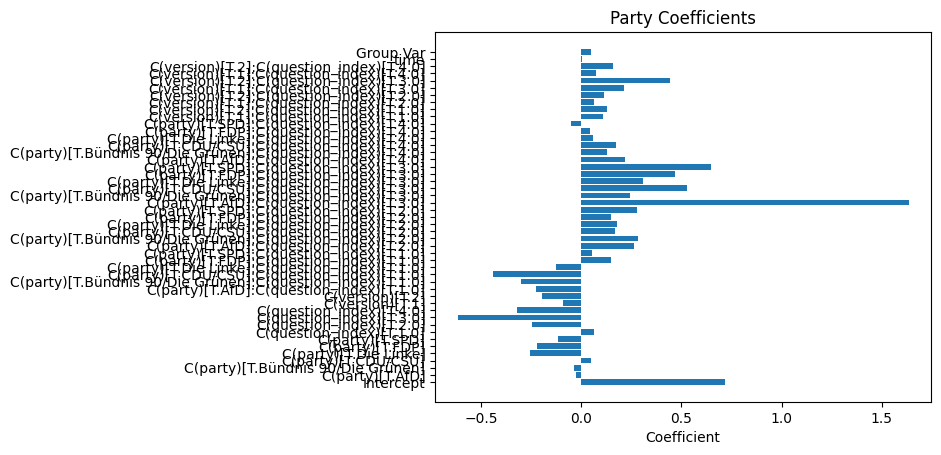

R^2: 0.17228386210044366
0.17227421922597425 0.4755537995990039 0.4150709127850611 0.0 0.002785791852537456
R^2: 0.17228386264022377


In [25]:


formatted_df_distance["party"] = formatted_df_distance["party"].astype("category")
formatted_df_distance["party"] = formatted_df_distance["party"].cat.reorder_categories(
    [
        "Default",
        "AfD",
        "Bündnis 90/Die Grünen",
        "CDU/CSU",
        "Die Linke",
        "FDP",
        "SPD",
    ],
    ordered=False,
)
formatted_df_distance["version"] = formatted_df_distance["version"].astype("category")


formatted_df_distance = formatted_df_distance[
    formatted_df_distance["time"] != 0
]  # Remove d0, as it is always zero




# mixed effects model for distance from initial opinion
groups = formatted_df_distance["repetition"].astype(str)
md = smf.mixedlm(
    "distance ~ time + C(party) * C(question_index) + C(version) * C(question_index)",
    formatted_df_distance,
    groups=groups,
)
mdf = md.fit()
print(mdf.summary())




# get C(party)[T.*] coefficients
party_coefs = mdf.params


# plot all the coefficients

plt.barh(party_coefs.index, party_coefs.values)
plt.xlabel("Coefficient")
plt.title("Party Coefficients")
plt.show()



### calculate R^2 variance


# calculate R^2
r2 = r2_score(formatted_df_distance["distance"], mdf.fittedvalues)
print(f"R^2: {r2}")

slope, intercept, r_value, p_value, std_err = stats.linregress(formatted_df_distance["distance"], mdf.fittedvalues)


print(slope, intercept, r_value, p_value, std_err)
print(f"R^2: {r_value**2}")

# Variance of opinions 

/var/folders/7m/xjp08lvs2dg885vy_yybj_2r0000gn/T/ipykernel_9981/2312822050.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  variance_df = pd.concat(


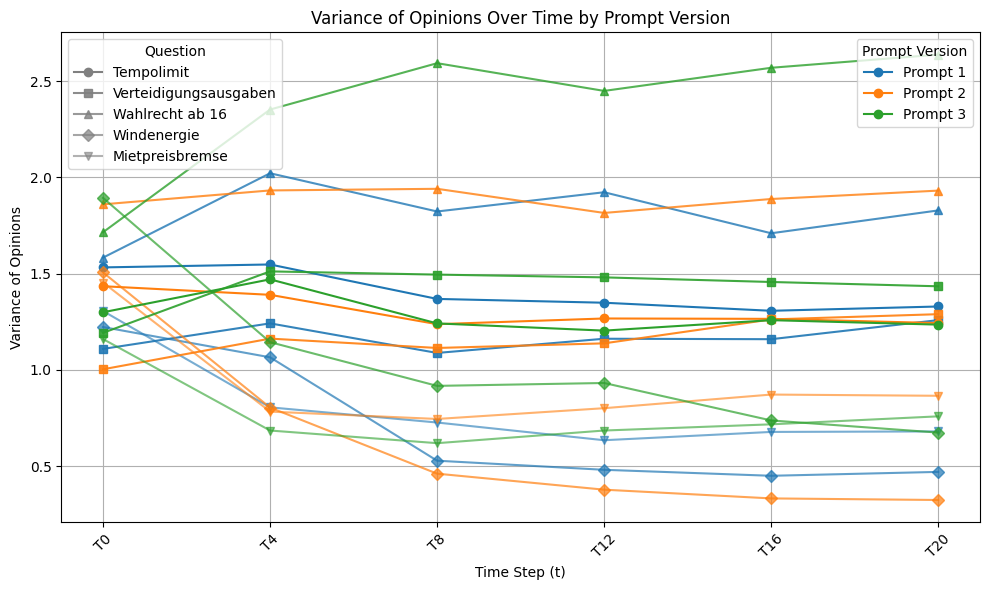

In [26]:
timesteps = [f"T{i}" for i in range(0, 21, 4)]
versions = bla["version"].unique()

variance_df = pd.DataFrame(columns=["version", "time", "variance", "question_index"])

for version in versions:
    for question_index in bla["question_index"].unique():
        for t in timesteps:
            # Filter for current version
            vals = bla[
                (bla["version"] == version) & (bla["question_index"] == question_index)
            ][t]
            variance = vals.var()
            variance_df = pd.concat(
                [
                    variance_df,
                    pd.DataFrame(
                        {
                            "version": [version],
                            "time": [t],
                            "variance": [variance],
                            "question_index": [question_index],
                        }
                    ),
                ],
                ignore_index=True,
            )


plt.figure(figsize=(10, 6))
ax = plt.gca()

# Store handles for legends
prompt_handles = []
question_handles = []
markers = ['o', 's', '^', 'D', 'v', 'P', '*']

for version_idx, version in enumerate(versions):
    for question_cnt, question_index in enumerate(
        variance_df["question_index"].unique()
    ):
        vdf = variance_df[
            (variance_df["version"] == version)
            & (variance_df["question_index"] == question_index)
        ]
        (line,) = ax.plot(
            vdf["time"],
            vdf["variance"],
            marker=markers[question_cnt % len(markers)],
            color=colors[version_idx],
            alpha=opaqueness[question_cnt],
            label=f"Prompt {version_idx} (Q{question_index})",
        )
        if question_cnt == 0:
            prompt_handles.append(line)
        if version_idx == 0:
            # Dummy lines for question legend
            (dummy,) = ax.plot(
                [],
                [],
                color="gray",
                marker=markers[question_cnt % len(markers)],
                alpha=opaqueness[question_cnt],
                label=f"Question {question_index}",
            )
            question_handles.append(dummy)

plt.xticks(timesteps, rotation=45)
plt.xlabel("Time Step (t)")
plt.ylabel("Variance of Opinions")
plt.title("Variance of Opinions Over Time by Prompt Version")

# First legend: Prompt Version (color)
legend1 = ax.legend(
    prompt_handles,
    [f"Prompt {i +1 }" for i in range(len(colors))],
    title="Prompt Version",
    loc="upper right",
)
ax.add_artist(legend1)

# Second legend: Question (opaqueness)
legend2 = ax.legend(
    question_handles,
    [QUESTIONS_SHORT[int(q)] for q in variance_df["question_index"].unique()],
    title="Question",
    loc="upper left",
)

plt.grid(True)
plt.tight_layout()
plt.show()

n_questions < len(axes)


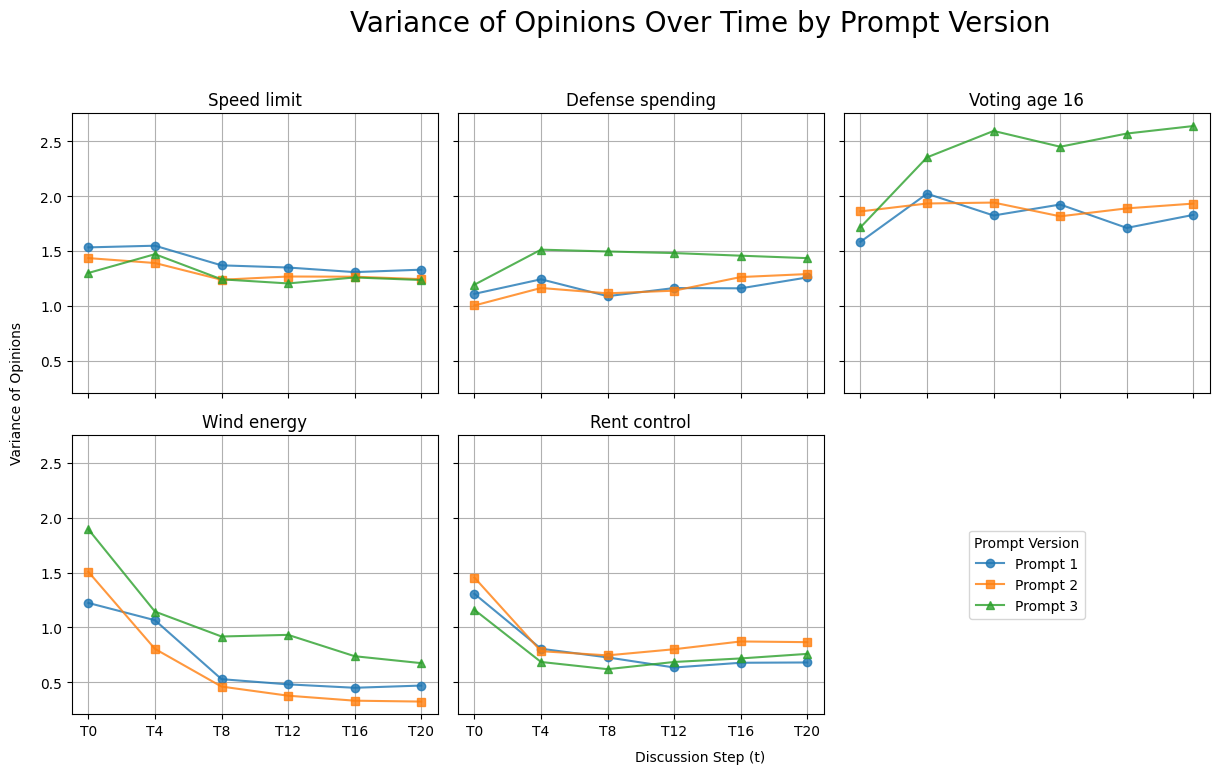

In [27]:
num_questions = variance_df["question_index"].nunique()
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 8), sharex=True, sharey=True)
fig.suptitle("Variance of Opinions Over Time by Prompt Version", fontsize=20)

# Flatten axes for easier indexing
axes = axes.flatten()

markers = ['o', 's', '^', 'D', 'v', 'P', '*']

for ax, question_index in zip(axes, variance_df["question_index"].unique()):
    for version_idx, version in enumerate(versions):
        vdf = variance_df[
            (variance_df["version"] == version)
            & (variance_df["question_index"] == question_index)
        ]
        ax.plot(
            vdf["time"],
            vdf["variance"],
            marker=markers[version_idx % len(markers)],
            color=colors[version_idx],
            alpha=0.8,
            label=f"Prompt {version_idx+1}",
        )

    ax.set_title(f"{QUESTIONS_SHORT_EN[int(question_index)]}")
    ax.grid(True)

# Hide any unused subplot (6th one)
for ax in axes[num_questions:+1]:
    ax.set_visible(False)

# Shared labels
fig.text(0.5, 0.04, "Discussion Step (t)", ha="center")
fig.text(0.04, 0.5, "Variance of Opinions", va="center", rotation="vertical")



if n_questions < len(axes):
    print("n_questions < len(axes)")
    legend_ax = axes[n_questions]
    legend_ax.axis("off")  # hide axis
    handles, labels = axes[0].get_legend_handles_labels()
    legend_ax.legend(handles, labels, title="Prompt Version", loc="center")


# Shared legend outside the grid
# fig.legend(
#     [f"Prompt {i+1}" for i in range(len(versions))],
#     title="Prompt Version",
#     loc="upper right"
# )

plt.tight_layout(rect=[0.05, 0.05, 0.85, 0.95])
plt.savefig("figures/variance_over_time_by_prompt_version.pdf")
plt.show()


In [28]:
# Ensure 'version' and 'question_index' are categorical for grouping
variance_df["version"] = variance_df["version"].astype("category")
variance_df["question_index"] = variance_df["question_index"].astype("category")

# Fit a mixed effects model: variance ~ time + (1 | version) + (1 | question_index)

if variance_df["time"].dtype == "object":
    variance_df["time"] = variance_df["time"].str.replace("T", "").astype(int)

variance_df["dummy_group"] = 1

vc = {"version": "0 + C(version)", "question_index": "0 + C(question_index)"}

model = smf.mixedlm(
    "variance ~ time",
    data=variance_df,
    groups="dummy_group",
    vc_formula=vc
)

result = model.fit()

print(result.summary())

            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   variance
No. Observations:    90        Method:               REML    
No. Groups:          1         Scale:                0.0650  
Min. group size:     90        Log-Likelihood:       -21.3637
Max. group size:     90        Converged:            Yes     
Mean group size:     90.0                                    
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           1.361    0.235  5.787 0.000  0.900  1.822
time               -0.011    0.004 -2.845 0.004 -0.019 -0.003
question_index Var  0.246    0.709                           
version Var         0.012    0.054                           



In [29]:
print(variance_df["time"].dtype)
if variance_df["time"].dtype != "int64":
    variance_df["time"] = variance_df["time"].str.replace("T", "").astype(float)
    variance_df["time"] = variance_df["time"].astype(int)

lm = ols("variance ~ time", data=variance_df, groups=variance_df["version"]).fit()
print(lm.summary())


int64
                            OLS Regression Results                            
Dep. Variable:               variance   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.921
Date:                Tue, 30 Sep 2025   Prob (F-statistic):              0.169
Time:                        13:20:03   Log-Likelihood:                -68.469
No. Observations:                  90   AIC:                             140.9
Df Residuals:                      88   BIC:                             145.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3612      0.098     13.910   

/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


In [30]:
for v in variance_df['version'].unique():
    for q in variance_df['question_index'].unique():
        variance_df_subset = variance_df[(variance_df['version'] == v) & (variance_df['question_index'] == q)].copy()
        if variance_df_subset["time"].dtype != "int64":
            variance_df_subset["time"] = variance_df_subset["time"].astype(int)
        
        lm = ols("variance ~ time", data=variance_df_subset).fit()
        print(f"Linear regression summary for version {v} and question {QUESTIONS_SHORT[int(q)]}:")
        print(f"time p = {lm.pvalues['time']:.4f}")
    


Linear regression summary for version 0.0 and question Tempolimit:
time p = 0.0192
Linear regression summary for version 0.0 and question Verteidigungsausgaben:
time p = 0.3742
Linear regression summary for version 0.0 and question Wahlrecht ab 16:
time p = 0.7983
Linear regression summary for version 0.0 and question Windenergie:
time p = 0.0231
Linear regression summary for version 0.0 and question Mietpreisbremse:
time p = 0.0771
Linear regression summary for version 1.0 and question Tempolimit:
time p = 0.0422
Linear regression summary for version 1.0 and question Verteidigungsausgaben:
time p = 0.0148
Linear regression summary for version 1.0 and question Wahlrecht ab 16:
time p = 0.8436
Linear regression summary for version 1.0 and question Windenergie:
time p = 0.0299
Linear regression summary for version 1.0 and question Mietpreisbremse:
time p = 0.2831
Linear regression summary for version 2.0 and question Tempolimit:
time p = 0.2551
Linear regression summary for version 2.0 a